In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 시트에서 데이터 불러오기
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)

# 컬럼명 확인
print("📋 현재 시트에 존재하는 컬럼명 목록:")
print(df_raw.columns.tolist())

NameError: name 'get_as_dataframe' is not defined

In [11]:
# ✅ Colab 환경에서 실행 가능한 전체 분석 자동화 코드 (덮어쓰기 버전)

# ✅ 1. 필수 라이브러리 설치
!pip install gspread gspread_dataframe oauth2client konlpy keybert bertopic openpyxl --quiet

# ✅ 2. 라이브러리 불러오기
import pandas as pd
from konlpy.tag import Okt
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# ✅ 3. 구글 인증
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 4. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()  # 공백 제거

# ✅ 5. 등록내용 기준 전처리
if '등록내용' not in df_raw.columns:
    raise ValueError("❌ '등록내용' 컬럼이 없습니다. 정확한 컬럼명을 확인해주세요.")
df = df_raw.dropna(subset=['등록내용']).copy()

# ✅ 6. 날짜 파싱
if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 7. 명사 키워드 추출 (2~10자)
okt = Okt()
df['명사추출'] = df['등록내용'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 8. 핵심 키워드 추출 (KeyBERT)
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['등록내용'].apply(lambda x: kw_model.extract_keywords(str(x), keyphrase_ngram_range=(1,2), top_n=5))

# ✅ 9. 토픽 분석 (BERTopic)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df["등록내용"].astype(str))
df['토픽'] = topics
df['토픽확률'] = probs

# ✅ 10. 요약 테이블 구성
지사별_건수 = df.groupby('관리지사').size().reset_index(name='상담건수')
구역별_키워드 = df.explode('명사추출').groupby(['담당상세', '명사추출']).size().reset_index(name='빈도수')
일자별_상담 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')
지사별_토픽 = df.groupby(['관리지사', '토픽']).size().reset_index(name='토픽건수')

# ✅ 11. 시트 덮어쓰기 저장 함수
def export_to_sheet(sheet_title, df_result):
    try:
        existing_ws = spreadsheet.worksheet(sheet_title)
        existing_ws.clear()
        set_with_dataframe(existing_ws, df_result)
    except:
        new_ws = spreadsheet.add_worksheet(title=sheet_title, rows="1000", cols="20")
        set_with_dataframe(new_ws, df_result)

# ✅ 12. 분석 결과 Google Sheets에 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사별_건수)
export_to_sheet("영업구역별키워드", 구역별_키워드)
export_to_sheet("일자별상담건수", 일자별_상담)
export_to_sheet("지사별토픽분포", 지사별_토픽)

print("✅ 분석 완료! 기존 시트에 덮어쓰기 완료. Looker Studio에서 시각화 가능해요.")


✅ 분석 완료! 기존 시트에 덮어쓰기 완료. Looker Studio에서 시각화 가능해요.


In [12]:
# ✅ Colab 환경에서 실행 가능한 전체 분석 자동화 코드 (덮어쓰기 버전)

# ✅ 1. 필수 라이브러리 설치
!pip install gspread gspread_dataframe oauth2client konlpy keybert bertopic openpyxl --quiet

# ✅ 2. 라이브러리 불러오기
import pandas as pd
from konlpy.tag import Okt
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# ✅ 3. 구글 인증
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 4. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()  # 공백 제거

# ✅ 5. 등록내용 기준 전처리
if '등록내용' not in df_raw.columns:
    raise ValueError("❌ '등록내용' 컬럼이 없습니다. 정확한 컬럼명을 확인해주세요.")
df = df_raw.dropna(subset=['등록내용']).copy()

# ✅ 6. 날짜 파싱
if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 7. 명사 키워드 추출 (2~10자)
okt = Okt()
df['명사추출'] = df['등록내용'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 8. 핵심 키워드 추출 (KeyBERT)
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['등록내용'].apply(lambda x: kw_model.extract_keywords(str(x), keyphrase_ngram_range=(1,2), top_n=5))

# ✅ 9. 토픽 분석 (BERTopic)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df["등록내용"].astype(str))
df['토픽'] = topics
df['토픽확률'] = probs

# ✅ 10. 요약 테이블 구성
지사별_건수 = df.groupby('관리지사').size().reset_index(name='상담건수')
구역별_키워드 = df.explode('명사추출').groupby(['담당상세', '명사추출']).size().reset_index(name='빈도수')
일자별_상담 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')
지사별_토픽 = df.groupby(['관리지사', '토픽']).size().reset_index(name='토픽건수')

# ✅ 11. 시트 덮어쓰기 저장 함수
def export_to_sheet(sheet_title, df_result):
    try:
        existing_ws = spreadsheet.worksheet(sheet_title)
        existing_ws.clear()
        set_with_dataframe(existing_ws, df_result)
    except:
        new_ws = spreadsheet.add_worksheet(title=sheet_title, rows="1000", cols="20")
        set_with_dataframe(new_ws, df_result)

# ✅ 12. 분석 결과 Google Sheets에 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사별_건수)
export_to_sheet("영업구역별키워드", 구역별_키워드)
export_to_sheet("일자별상담건수", 일자별_상담)
export_to_sheet("지사별토픽분포", 지사별_토픽)

print("✅ 분석 완료! 기존 시트에 덮어쓰기 완료. Looker Studio에서 시각화 가능해요.")


✅ 분석 완료! 기존 시트에 덮어쓰기 완료. Looker Studio에서 시각화 가능해요.


In [ ]:
# ✅ 텍스트 분석 대상 컬럼 합치기
df['분석대상문장'] = df[['VOC유형', 'VOC유형소', '등록내용', '처리유형']].astype(str).agg(' '.join, axis=1)

# ✅ 형태소 분석 기반 키워드 추출
okt = Okt()
df['명사추출'] = df['분석대상문장'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 핵심 키워드 (KeyBERT)
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['분석대상문장'].apply(lambda x: kw_model.extract_keywords(str(x), keyphrase_ngram_range=(1,2), top_n=5))

# ✅ BERTopic 토픽 분석
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df["분석대상문장"].astype(str))

# ✅ 결과 저장
df['토픽'] = topics
df['토픽확률'] = probs

In [6]:
# ✅ Colab 환경에서 실행 가능한 VOC 통합 텍스트 분석 자동화 코드 (등록내용 + VOC유형 기반, 안정형 저장 포함)

# ✅ 1. 필수 라이브러리 설치
!pip install gspread gspread_dataframe oauth2client konlpy keybert bertopic openpyxl --quiet

# ✅ 2. 라이브러리 불러오기
import pandas as pd
from konlpy.tag import Okt
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# ✅ 3. 구글 인증
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 4. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()  # 공백 제거

# ✅ 5. 분석 대상 구성: VOC유형, VOC유형소, 등록내용, 처리유형
text_cols = ['VOC유형', 'VOC유형소', '등록내용', '처리유형']
for col in text_cols:
    if col not in df_raw.columns:
        raise ValueError(f"❌ '{col}' 컬럼이 존재하지 않습니다.")

df = df_raw.dropna(subset=['등록내용']).copy()
df['분석대상문장'] = df[text_cols].astype(str).agg(' '.join, axis=1)

# ✅ 6. 날짜 파싱
if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 7. 형태소 기반 키워드 추출 (2~10자 명사)
okt = Okt()
df['명사추출'] = df['분석대상문장'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 8. 핵심 키워드 추출 (KeyBERT)
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['분석대상문장'].apply(lambda x: kw_model.extract_keywords(str(x), keyphrase_ngram_range=(1,2), top_n=5))

# ✅ 9. 토픽 분석 (BERTopic)
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(df["분석대상문장"].astype(str))
df['토픽'] = topics
df['토픽확률'] = probs

# ✅ 10. 요약 테이블 구성
지사별_건수 = df.groupby('관리지사').size().reset_index(name='상담건수')
구역별_키워드 = df.explode('명사추출').groupby(['담당상세', '명사추출']).size().reset_index(name='빈도수')
일자별_상담 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')
지사별_토픽 = df.groupby(['관리지사', '토픽']).size().reset_index(name='토픽건수')

# ✅ 11. 시트 덮어쓰기 저장 함수 (안정형)
def export_to_sheet(sheet_title, df_result):
    try:
        sheet_names = [ws.title for ws in spreadsheet.worksheets()]
        if sheet_title in sheet_names:
            existing_ws = spreadsheet.worksheet(sheet_title)
            existing_ws.clear()
            set_with_dataframe(existing_ws, df_result)
        else:
            new_ws = spreadsheet.add_worksheet(title=sheet_title, rows="1000", cols="20")
            set_with_dataframe(new_ws, df_result)
    except Exception as e:
        print(f"❌ 시트 저장 실패 ({sheet_title}): {e}")

# ✅ 12. 분석 결과 Google Sheets에 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사별_건수)
export_to_sheet("영업구역별키워드", 구역별_키워드)
export_to_sheet("일자별상담건수", 일자별_상담)
export_to_sheet("지사별토픽분포", 지사별_토픽)

print("✅ 분석 완료! VOC유형 기반 텍스트 결합 후 고급 분석 적용. Looker Studio에서 시각화 가능해요.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ 분석 완료! VOC유형 기반 텍스트 결합 후 고급 분석 적용. Looker Studio에서 시각화 가능해요.


In [5]:
# ✅ 고도화된 VOC 통합 텍스트 분석 자동화 코드 (긴 텍스트 기반 고정밀 토픽 적용)

# ❗ 주의: 이 코드는 Google Colab 환경에서 실행되어야 하며, 필요한 라이브러리는 아래 명령어로 설치하세요:
# !pip install gspread gspread_dataframe oauth2client konlpy keybert bertopic sentence-transformers openpyxl

# ✅ 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# konlpy는 Colab에서 별도 설치 필요
try:
    from konlpy.tag import Okt
except ModuleNotFoundError:
    raise ModuleNotFoundError("konlpy가 설치되어 있지 않습니다. 다음 명령어를 실행하세요: !pip install konlpy")

# ✅ 2. 구글 인증 (환경변수 또는 안전한 경로로 설정하세요)
json_keyfile_path = os.getenv("GOOGLE_CREDENTIALS_PATH", "/content/drive/My Drive/Key/credentials.json")
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 3. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()

# ✅ 4. 분석 대상 구성: VOC유형, VOC유형소, 등록내용, 처리유형
text_cols = ['VOC유형', 'VOC유형소', '등록내용', '처리유형']
for col in text_cols:
    if col not in df_raw.columns:
        raise ValueError(f"❌ '{col}' 컬럼이 존재하지 않습니다.")

df = df_raw.dropna(subset=['등록내용']).copy()
df['분석대상문장'] = df[text_cols].astype(str).agg(' '.join, axis=1)

# ✅ 5. 날짜 파싱
if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 6. 형태소 기반 키워드 추출 (명사 2~10자)
okt = Okt()
df['명사추출'] = df['분석대상문장'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 7. KeyBERT 핵심 키워드 추출 (고정밀)
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['분석대상문장'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(2, 4), stop_words=None, top_n=5))

# ✅ 8. BERTopic 고정밀 분석 (문장 임베딩 기반)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
vectorizer_model = CountVectorizer(ngram_range=(2, 5), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, embedding_model=embedding_model, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df["분석대상문장"].astype(str))
df['토픽'] = topics

# ✅ 9. 토픽 확률 중 최고값만 저장
if probs is not None:
    df['토픽확률'] = [np.max(p) if isinstance(p, (list, np.ndarray)) else None for p in probs]
else:
    df['토픽확률'] = None

# ✅ 10. 요약 테이블 구성
지사별_건수 = df.groupby('관리지사').size().reset_index(name='상담건수')
구역별_키워드 = df.explode('명사추출').groupby(['담당상세', '명사추출']).size().reset_index(name='빈도수')
일자별_상담 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')
지사별_토픽 = df.groupby(['관리지사', '토픽']).size().reset_index(name='토픽건수')

# ✅ 11. 시트 덮어쓰기 또는 버전 저장 함수

def export_to_sheet(sheet_title, df_result, allow_versioning=False):
    try:
        sheet_names = [ws.title for ws in spreadsheet.worksheets()]
        final_title = sheet_title
        if allow_versioning and sheet_title in sheet_names:
            now = datetime.now().strftime("_%Y%m%d_%H%M")
            final_title = f"{sheet_title}{now}"

        if final_title in sheet_names:
            existing_ws = spreadsheet.worksheet(final_title)
            existing_ws.clear()
            set_with_dataframe(existing_ws, df_result)
        else:
            new_ws = spreadsheet.add_worksheet(title=final_title, rows="1000", cols="20")
            set_with_dataframe(new_ws, df_result)
        print(f"✅ 저장 완료: {final_title}")
    except Exception as e:
        print(f"❌ 시트 저장 실패 ({sheet_title}): {e}")

# ✅ 12. 분석 결과 Google Sheets에 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사별_건수, allow_versioning=True)
export_to_sheet("영업구역별키워드", 구역별_키워드, allow_versioning=True)
export_to_sheet("일자별상담건수", 일자별_상담, allow_versioning=True)
export_to_sheet("지사별토픽분포", 지사별_토픽, allow_versioning=True)

print("✅ 고정밀 텍스트 분석 완료! ngram 확장 및 문장 임베딩 기반 토픽으로 Looker Studio 시각화에 최적화.")


ModuleNotFoundError: No module named 'keybert'

In [7]:
# 시트에서 데이터 불러오기
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)

# 컬럼명 확인
print("📋 현재 시트에 존재하는 컬럼명 목록:")
print(df_raw.columns.tolist())

📋 현재 시트에 존재하는 컬럼명 목록:
['상태', '지령여부', '고객번호', '계약번호', '서비스번호', '고객명', '상호', 'VOC유형대', 'VOC유형중', 'VOC유형소', 'VOC유형', '해지상세', '등록내용', '처리자', '처리유형', '처리내용', '담당유형', '담당상세', '접수일시', '처리완료일시', '결재일자', '등록경로', 'RAS ID', '접수번호', '클레임구분', '서비스대', '서비스중', '서비스소', '회선방식대', '회선방식중', '서비스개시일', '계약종료일', '월정료(VAT미포함)', '접수횟수', '본사', '팀', 'P/N/G', '4대지악유무', '관리본부', '관리지사', '방문활동 완료여부']


In [ ]:
# ✅ 상태 기준 집계표 생성
상태_집계 = (
    df.groupby(['관리지사', '상태'])
    .size()
    .reset_index(name='건수')
    .pivot(index='관리지사', columns='상태', values='건수')
    .fillna(0)
    .reset_index()
)

# ✅ 숫자형 변환
for col in 상태_집계.columns[1:]:
    상태_집계[col] = 상태_집계[col].astype(int)

# ✅ 시트 저장
export_to_sheet("지사별상태현황", 상태_집계, allow_versioning=True)

NameError: name 'df' is not defined

In [ ]:
# ✅ 필수 컬럼 존재 확인
필수컬럼 = ['관리본부', '관리지사', '계약번호', '상태', 'VOC유형대', 'VOC유형중', 'VOC유형소', '접수일시']
for col in 필수컬럼:
    if col not in df.columns:
        raise ValueError(f"❌ 필수 컬럼 누락됨: {col}")

# ✅ 1. 지사/본부별 상담 건수
지사현황 = df.groupby(['관리본부', '관리지사']).agg({'계약번호': 'count'}).reset_index()
지사현황.rename(columns={'계약번호': '상담건수'}, inplace=True)

# ✅ 2. 지사별 상태별 상담 분포
지사상태 = (
    df.groupby(['관리지사', '상태'])
    .size()
    .reset_index(name='건수')
    .pivot(index='관리지사', columns='상태', values='건수')
    .fillna(0)
    .reset_index()
)

# ✅ 3. VOC 유형 대/중/소 조합별 빈도
voc조합 = df.groupby(['VOC유형대', 'VOC유형중', 'VOC유형소']).size().reset_index(name='건수')
voc조합 = voc조합.sort_values('건수', ascending=False)

# ✅ 4. 접수일자 기준 일자별 건수
df['접수일'] = pd.to_datetime(df['접수일시'], errors='coerce').dt.date
일자별 = df.groupby(['접수일', '관리지사']).size().reset_index(name='일자별상담건수')

# ✅ 시트로 저장
export_to_sheet("지사별_총건수", 지사현황, allow_versioning=True)
export_to_sheet("지사별_상태분포", 지사상태, allow_versioning=True)
export_to_sheet("VOC_유형조합", voc조합, allow_versioning=True)
export_to_sheet("일자별_상담건수", 일자별, allow_versioning=True)

print("✅ VOC 현황 요약 시트 4개 생성 완료!")

NameError: name 'df' is not defined

In [ ]:
# ✅ 기본 설치
!pip install --upgrade pip
!pip install keybert bertopic konlpy sentence-transformers openpyxl gspread gspread_dataframe oauth2client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# ✅ 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# konlpy 설치 확인
try:
    from konlpy.tag import Okt
except ModuleNotFoundError:
    raise ModuleNotFoundError("konlpy가 설치되어 있지 않습니다. ➡️ !pip install konlpy 실행하세요!")

# ✅ 3. 구글 인증
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 3. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()

# ✅ 4. 데이터 준비
df = df_raw.dropna(subset=['등록내용']).copy()
df['분석대상문장'] = df[['VOC유형대', 'VOC유형중', 'VOC유형소', '등록내용']].astype(str).agg(' '.join, axis=1)

if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 5. 형태소 키워드 추출
okt = Okt()
df['명사추출'] = df['분석대상문장'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 6. KeyBERT 키워드 추출
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['분석대상문장'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(2, 4), stop_words=None, top_n=5))

# ✅ 7. BERTopic 분석
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
vectorizer_model = CountVectorizer(ngram_range=(2, 5), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, embedding_model=embedding_model, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df["분석대상문장"].astype(str))
df['토픽'] = topics
df['토픽확률'] = [np.max(p) if isinstance(p, (list, np.ndarray)) else None for p in probs] if probs is not None else None

# ✅ 8. 요약 집계 현황 생성
필수컬럼 = ['관리본부', '관리지사', '계약번호', '상태', 'VOC유형대', 'VOC유형중', 'VOC유형소', '접수일시']
for col in 필수컬럼:
    if col not in df.columns:
        raise ValueError(f"❌ 필수 컬럼 누락됨: {col}")

# ▶️ 집계별 테이블
지사현황 = df.groupby(['관리본부', '관리지사']).agg({'계약번호': 'count'}).reset_index().rename(columns={'계약번호': '상담건수'})
지사상태 = df.groupby(['관리지사', '상태']).size().reset_index(name='건수').pivot(index='관리지사', columns='상태', values='건수').fillna(0).reset_index()
voc조합 = df.groupby(['VOC유형대', 'VOC유형중', 'VOC유형소']).size().reset_index(name='건수').sort_values('건수', ascending=False)
일자별 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')

# ✅ 9. 시트 저장 함수
def export_to_sheet(sheet_title, df_result, allow_versioning=False):
    try:
        sheet_names = [ws.title for ws in spreadsheet.worksheets()]
        final_title = sheet_title
        if allow_versioning and sheet_title in sheet_names:
            now = datetime.now().strftime("_%Y%m%d_%H%M")
            final_title = f"{sheet_title}{now}"

        if final_title in sheet_names:
            existing_ws = spreadsheet.worksheet(final_title)
            existing_ws.clear()
            set_with_dataframe(existing_ws, df_result)
        else:
            new_ws = spreadsheet.add_worksheet(title=final_title, rows="1000", cols="20")
            set_with_dataframe(new_ws, df_result)
        print(f"✅ 저장 완료: {final_title}")
    except Exception as e:
        print(f"❌ 시트 저장 실패 ({sheet_title}): {e}")

# ✅ 10. 분석 결과 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사현황, allow_versioning=True)
export_to_sheet("지사별상태분포", 지사상태, allow_versioning=True)
export_to_sheet("VOC_유형조합", voc조합, allow_versioning=True)
export_to_sheet("일자별상담건수", 일자별, allow_versioning=True)

print("✅ 전체 VOC 통합 분석 및 현황 요약 완료! Looker Studio 연결 준비 끝났어요.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/Key/credentials.json'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
# ✅ 0. 필요한 라이브러리 설치
# (최초 1회만 실행)
# !pip install keybert bertopic konlpy sentence-transformers openpyxl gspread gspread_dataframe oauth2client

!pip install keybert bertopic konlpy sentence-transformers openpyxl gspread gspread_dataframe oauth2client

# ✅ 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import os
from datetime import datetime
from keybert import KeyBERT
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from oauth2client.service_account import ServiceAccountCredentials
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe

# ✅ konlpy 설치 확인
try:
    from konlpy.tag import Okt
except ModuleNotFoundError:
    raise ModuleNotFoundError("konlpy가 설치되어 있지 않습니다. ➡️ !pip install konlpy 실행 후 다시 시도하세요!")

# ✅ 2. 구글 드라이브 마운트 및 인증
from google.colab import drive
drive.mount('/content/drive')

json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"  # 경로 정확히 확인
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 3. Google Sheets 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()

# ✅ 4. 데이터 준비
df = df_raw.dropna(subset=['등록내용']).copy()
df['분석대상문장'] = df[['VOC유형대', 'VOC유형중', 'VOC유형소', '등록내용']].astype(str).agg(' '.join, axis=1)

if '접수일시' in df.columns:
    df['접수일시'] = pd.to_datetime(df['접수일시'], errors='coerce')
    df['일자'] = df['접수일시'].dt.date
    df['월'] = df['접수일시'].dt.to_period('M')
    df['주'] = df['접수일시'].dt.to_period('W')

# ✅ 5. 형태소 키워드 추출
okt = Okt()
df['명사추출'] = df['분석대상문장'].apply(lambda x: [w for w in okt.nouns(str(x)) if 2 <= len(w) <= 10])

# ✅ 6. KeyBERT 키워드 추출
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')
df['키워드'] = df['분석대상문장'].apply(lambda x: kw_model.extract_keywords(x, keyphrase_ngram_range=(2, 4), stop_words=None, top_n=5))

# ✅ 7. BERTopic 토픽 분석
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
vectorizer_model = CountVectorizer(ngram_range=(2, 5), stop_words="english")
topic_model = BERTopic(language="multilingual", vectorizer_model=vectorizer_model, embedding_model=embedding_model, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df["분석대상문장"].astype(str))
df['토픽'] = topics
df['토픽확률'] = [np.max(p) if isinstance(p, (list, np.ndarray)) else None for p in probs] if probs is not None else None

# ✅ 8. 필수 컬럼 검증
필수컬럼 = ['관리본부', '관리지사', '계약번호', '상태', 'VOC유형대', 'VOC유형중', 'VOC유형소', '접수일시']
for col in 필수컬럼:
    if col not in df.columns:
        raise ValueError(f"❌ 필수 컬럼 누락됨: {col}")

# ✅ 9. 현황 요약 테이블 생성
# ▶️ 지사별 상담 건수
지사현황 = df.groupby(['관리본부', '관리지사']).agg({'계약번호': 'count'}).reset_index().rename(columns={'계약번호': '상담건수'})

# ▶️ 지사별 상태별 건수
지사상태 = df.groupby(['관리지사', '상태']).size().reset_index(name='건수').pivot(index='관리지사', columns='상태', values='건수').fillna(0).reset_index()

# ▶️ VOC유형 조합별 건수
voc조합 = df.groupby(['VOC유형대', 'VOC유형중', 'VOC유형소']).size().reset_index(name='건수').sort_values('건수', ascending=False)

# ▶️ 일자별 상담 건수
일자별 = df.groupby(['일자', '관리지사']).size().reset_index(name='일자별상담건수')

# ✅ 10. Google Sheets로 저장 함수
def export_to_sheet(sheet_title, df_result, allow_versioning=False):
    try:
        sheet_names = [ws.title for ws in spreadsheet.worksheets()]
        final_title = sheet_title
        if allow_versioning and sheet_title in sheet_names:
            now = datetime.now().strftime("_%Y%m%d_%H%M")
            final_title = f"{sheet_title}{now}"

        if final_title in sheet_names:
            existing_ws = spreadsheet.worksheet(final_title)
            existing_ws.clear()
            set_with_dataframe(existing_ws, df_result)
        else:
            new_ws = spreadsheet.add_worksheet(title=final_title, rows="1000", cols="20")
            set_with_dataframe(new_ws, df_result)
        print(f"✅ 저장 완료: {final_title}")
    except Exception as e:
        print(f"❌ 시트 저장 실패 ({sheet_title}): {e}")

# ✅ 11. 결과 시트 저장
export_to_sheet("상세데이터", df)
export_to_sheet("지사별상담건수", 지사현황, allow_versioning=True)
export_to_sheet("지사별상태분포", 지사상태, allow_versioning=True)
export_to_sheet("VOC_유형조합", voc조합, allow_versioning=True)
export_to_sheet("일자별상담건수", 일자별, allow_versioning=True)

print("✅ 전체 VOC 분석 및 현황 요약 완료! Looker Studio 연결 준비 끝났어요.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ 저장 완료: 상세데이터
✅ 저장 완료: 지사별상담건수_20250426_1014
✅ 저장 완료: 지사별상태분포
✅ 저장 완료: VOC_유형조합
✅ 저장 완료: 일자별상담건수_20250426_1014
✅ 전체 VOC 분석 및 현황 요약 완료! Looker Studio 연결 준비 끝났어요.


In [ ]:
# ✅ 1. 데이터 준비 (VOC유형소 기준으로)
df = df_raw[['관리지사', 'VOC유형소']].dropna()

# ✅ 2. 관리지사별 VOC유형소 건수 집계
지사별_voc소 = (
    df.groupby(['관리지사', 'VOC유형소'])
    .size()
    .reset_index(name='건수')
)

# ✅ 3. 시각화 ① - 전체 관리지사 + VOC유형소 (누적 막대 그래프)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22, 10))

for 지사 in 지사별_voc소['관리지사'].unique():
    temp = 지사별_voc소[지사별_voc소['관리지사'] == 지사]
    plt.bar(temp['VOC유형소'], temp['건수'], label=지사)

plt.xticks(rotation=90)
plt.xlabel('VOC 유형소', fontsize=12)
plt.ylabel('건수', fontsize=12)
plt.title('전체 관리지사별 VOC유형소 건수 분포', fontsize=16)
plt.legend(title='관리지사', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ 4. 시각화 ② - 관리지사별 개별 그래프
지사목록 = 지사별_voc소['관리지사'].unique()

for 지사 in 지사목록:
    temp = 지사별_voc소[지사별_voc소['관리지사'] == 지사]
    plt.figure(figsize=(18, 6))
    sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')
    plt.title(f'{지사} 관리지사 - VOC유형소별 상담 건수', fontsize=16)
    plt.xticks(rotation=75)
    plt.xlabel('VOC유형소', fontsize=12)
    plt.ylabel('건수', fontsize=12)
    plt.tight_layout()
    plt.show()

# ✅ 5. 시각화 ③ - 전체 VOC유형소 상위 10개 (한눈에 보기)
voc소_상위10 = (
    df['VOC유형소']
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'index': 'VOC유형소', 'VOC유형소': '건수'})
)

plt.figure(figsize=(12, 6))
sns.barplot(x='VOC유형소', y='건수', data=voc소_상위10, palette='Set2')
plt.title('VOC유형소 상위 10개 상담건수', fontsize=16)
plt.xticks(rotation=45)
plt.xlabel('VOC유형소', fontsize=12)
plt.ylabel('건수', fontsize=12)
plt.tight_layout()
plt.show()


NameError: name 'df_raw' is not defined

In [2]:
# ✅ Google 인증
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe

json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# ✅ 구글 스프레드시트 열기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)

# ✅ 데이터프레임 변환
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()  # 컬럼 공백 제거


In [4]:
# ✅ 4. Google Sheets에서 데이터 불러오기
sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()  # 공백 제거


In [7]:
# ✅ 한글폰트 설정 (NanumGothic)
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False

NameError: name 'fm' is not defined

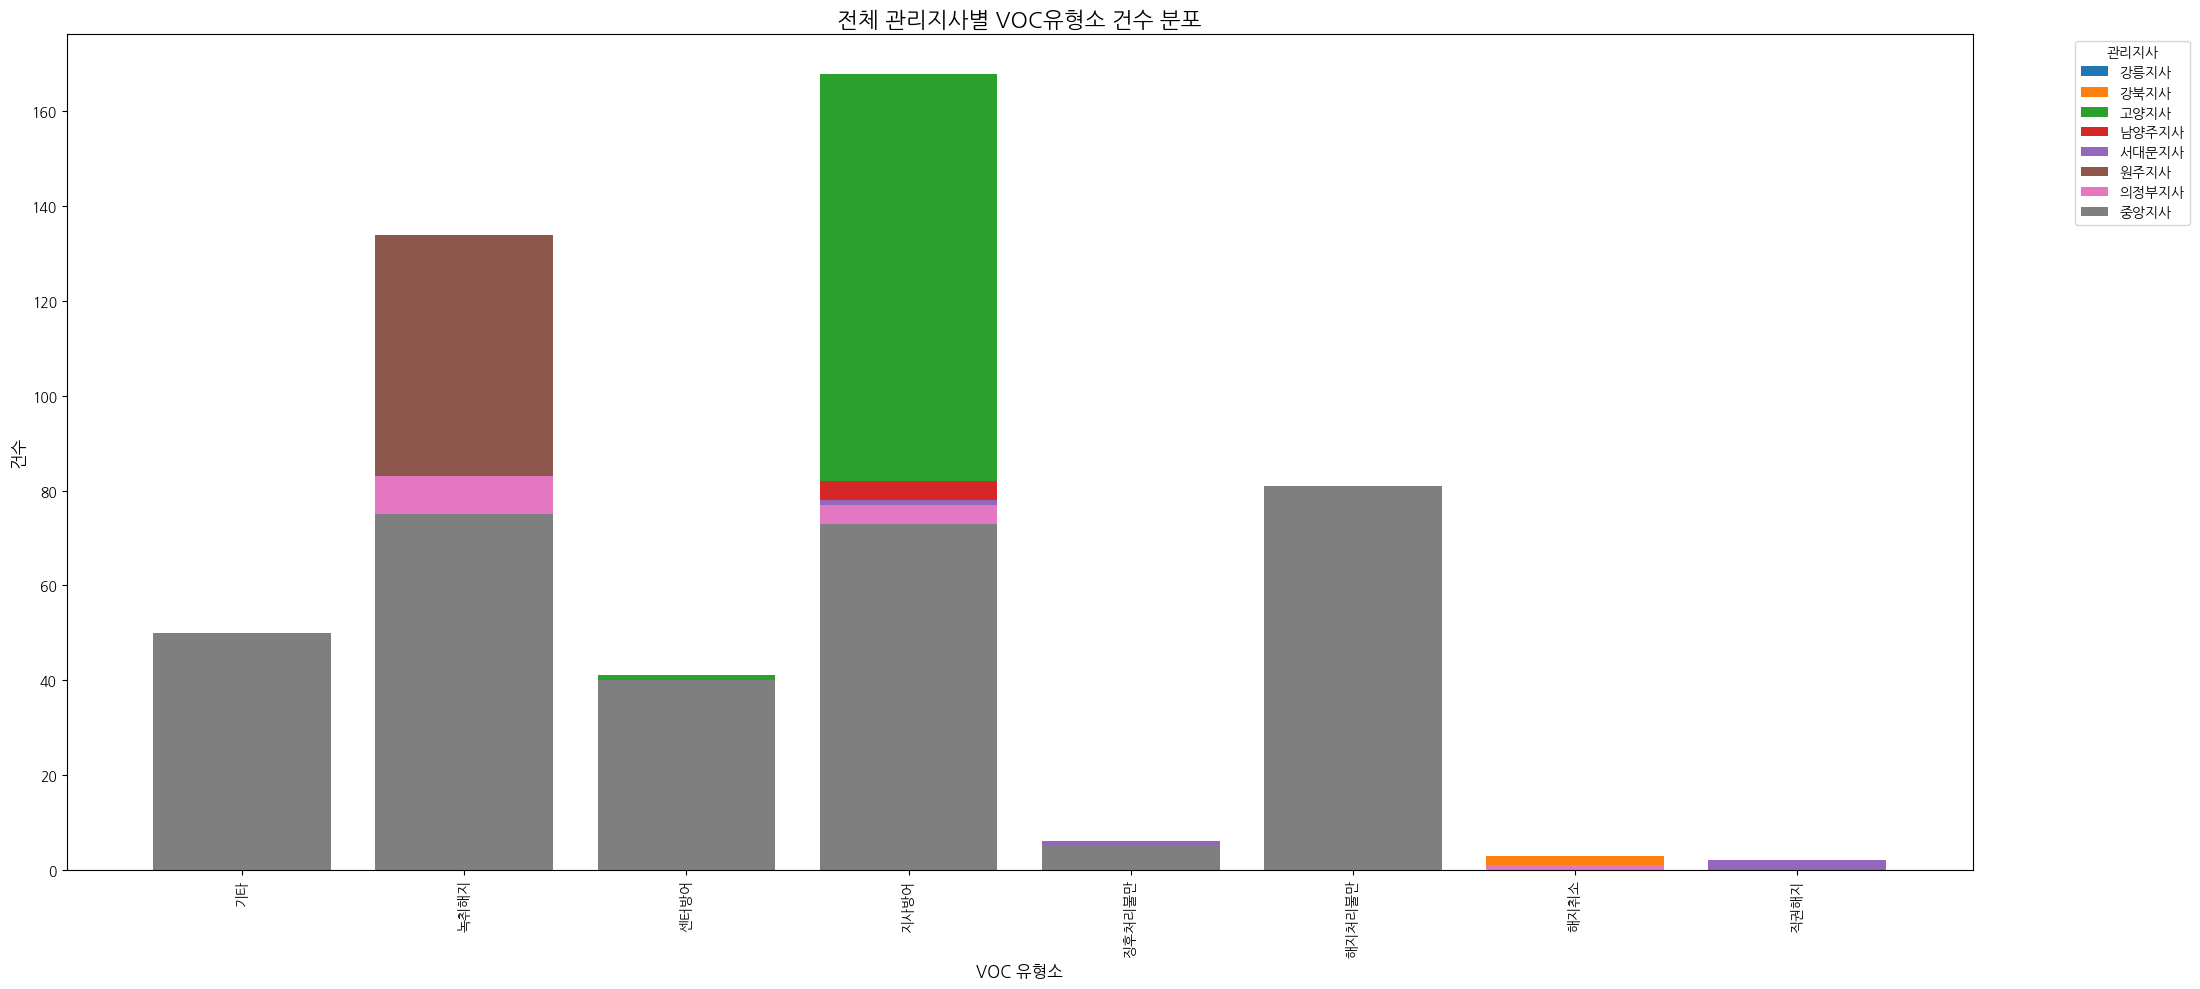

In [13]:
# ✅ 5. 데이터 준비 (VOC유형소 기준)
df = df_raw[['관리지사', 'VOC유형소']].dropna()

# ✅ 6. 관리지사별 VOC유형소 건수 집계
지사별_voc소 = (
    df.groupby(['관리지사', 'VOC유형소'])
    .size()
    .reset_index(name='건수')
)

# ✅ 7. 전체 관리지사별 VOC유형소 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(22, 10))

for 지사 in 지사별_voc소['관리지사'].unique():
    temp = 지사별_voc소[지사별_voc소['관리지사'] == 지사]
    plt.bar(temp['VOC유형소'], temp['건수'], label=지사)

plt.xticks(rotation=90)
plt.xlabel('VOC 유형소', fontsize=12)
plt.ylabel('건수', fontsize=12)
plt.title('전체 관리지사별 VOC유형소 건수 분포', fontsize=16)
plt.legend(title='관리지사', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 나눔고딕 폰트 적용 완료
✅ 데이터 로드 완료: (2134, 41)


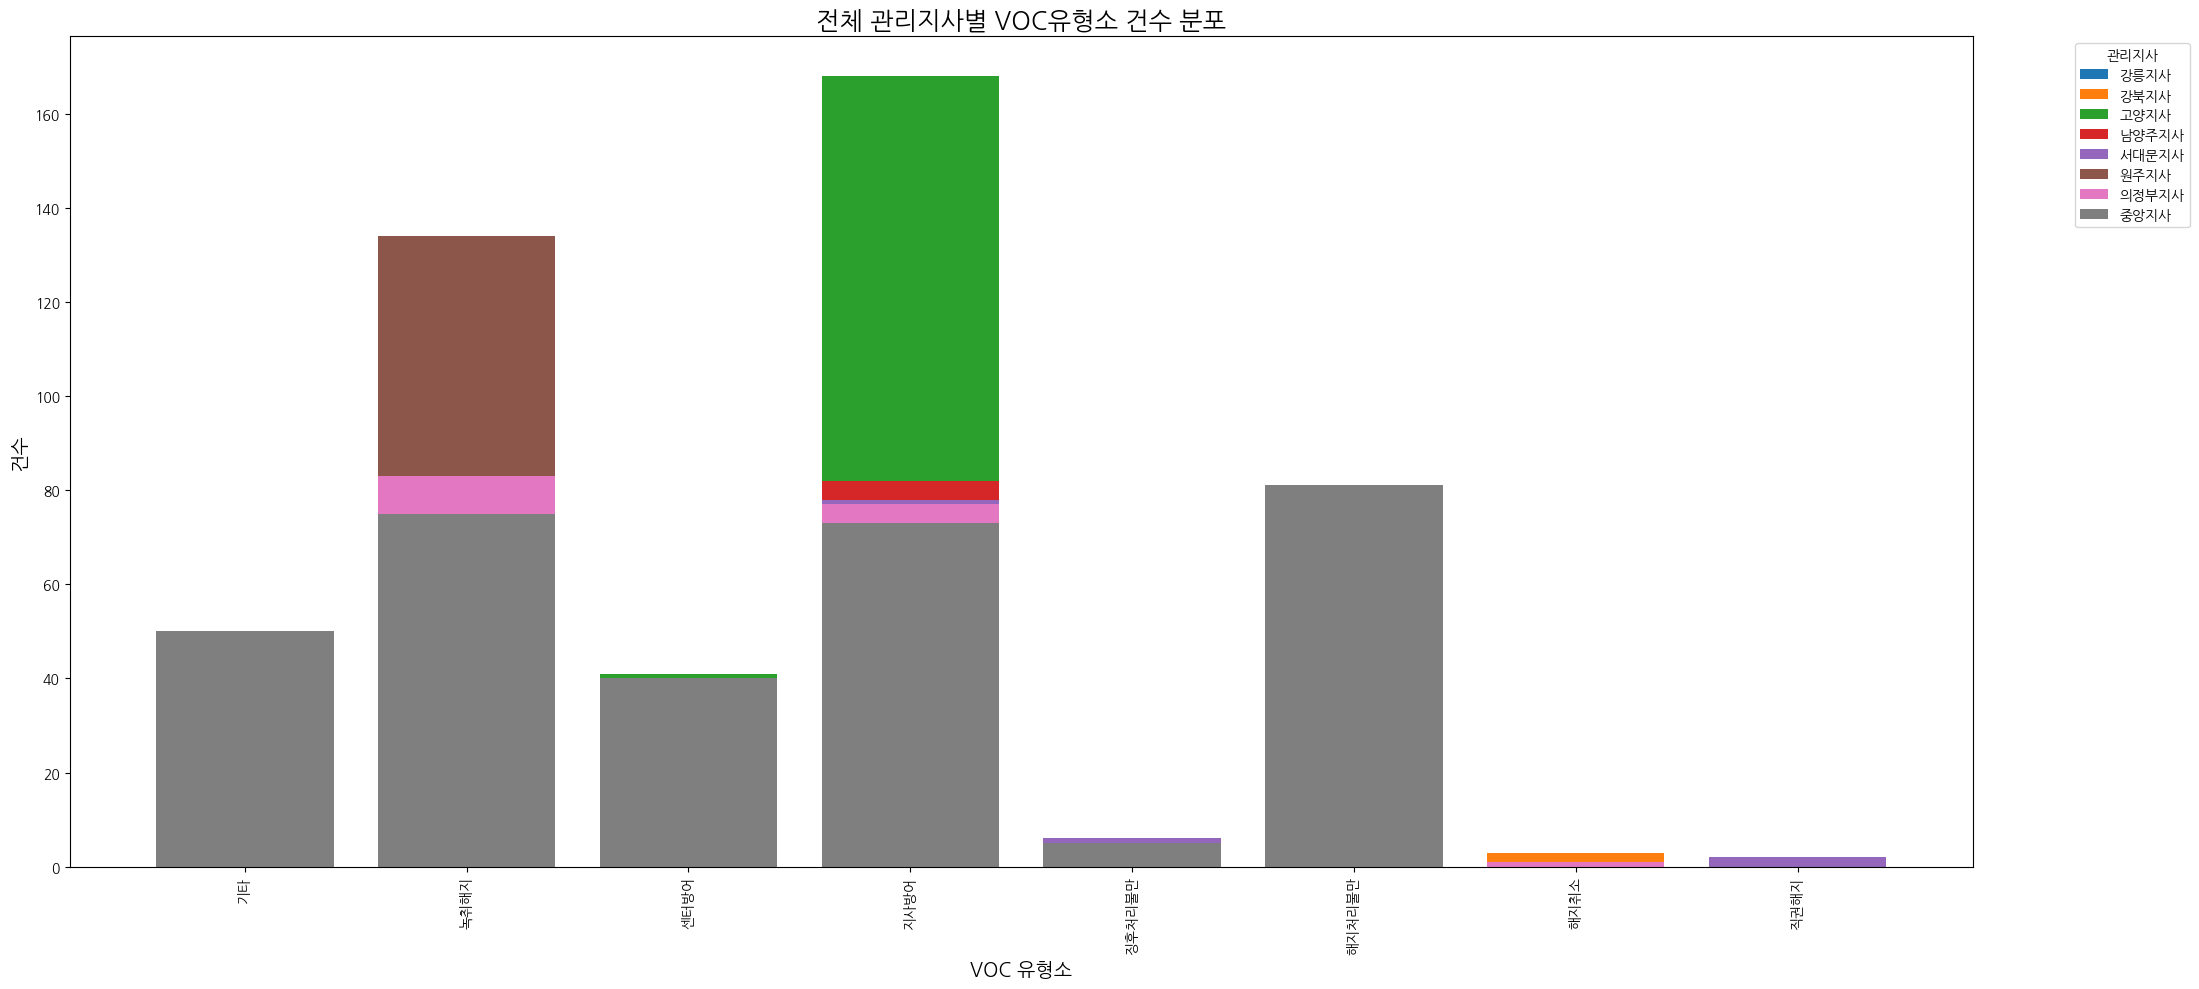

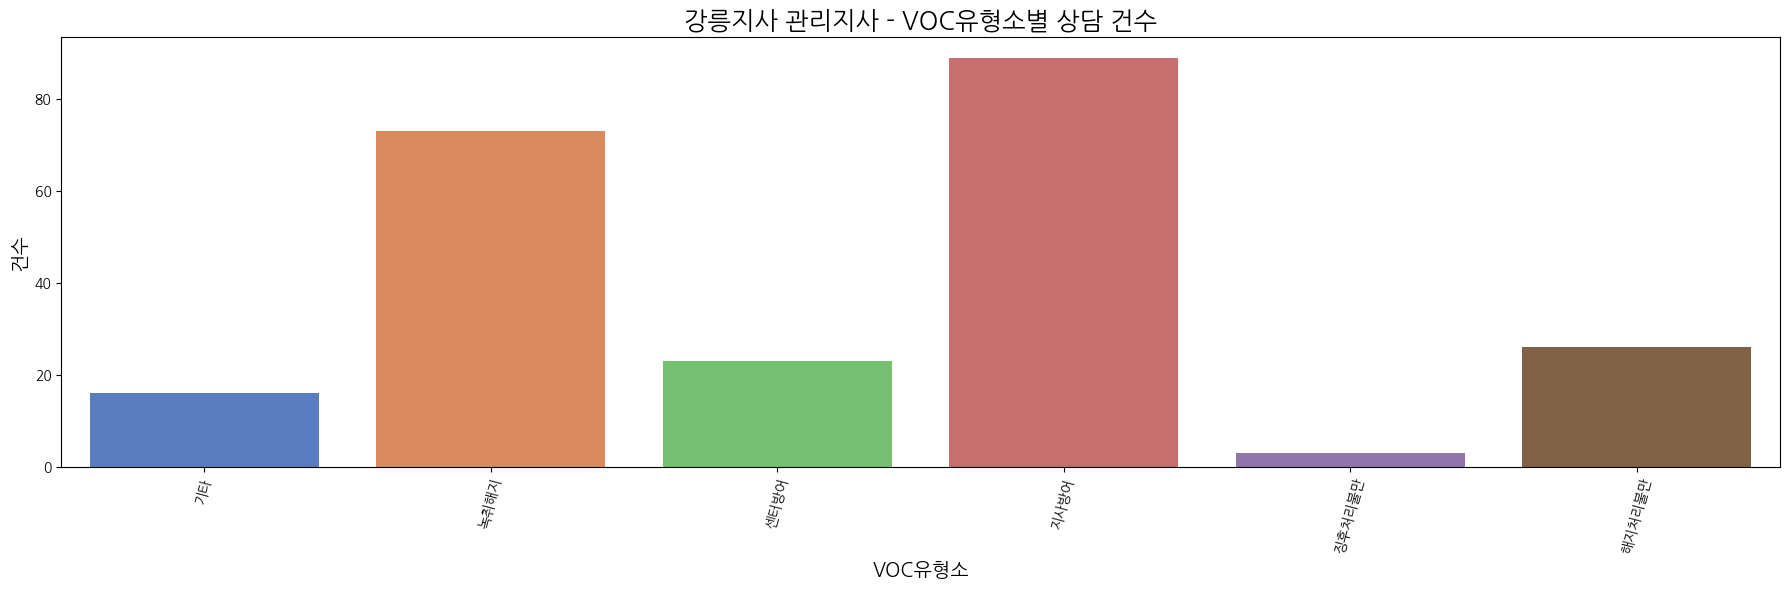

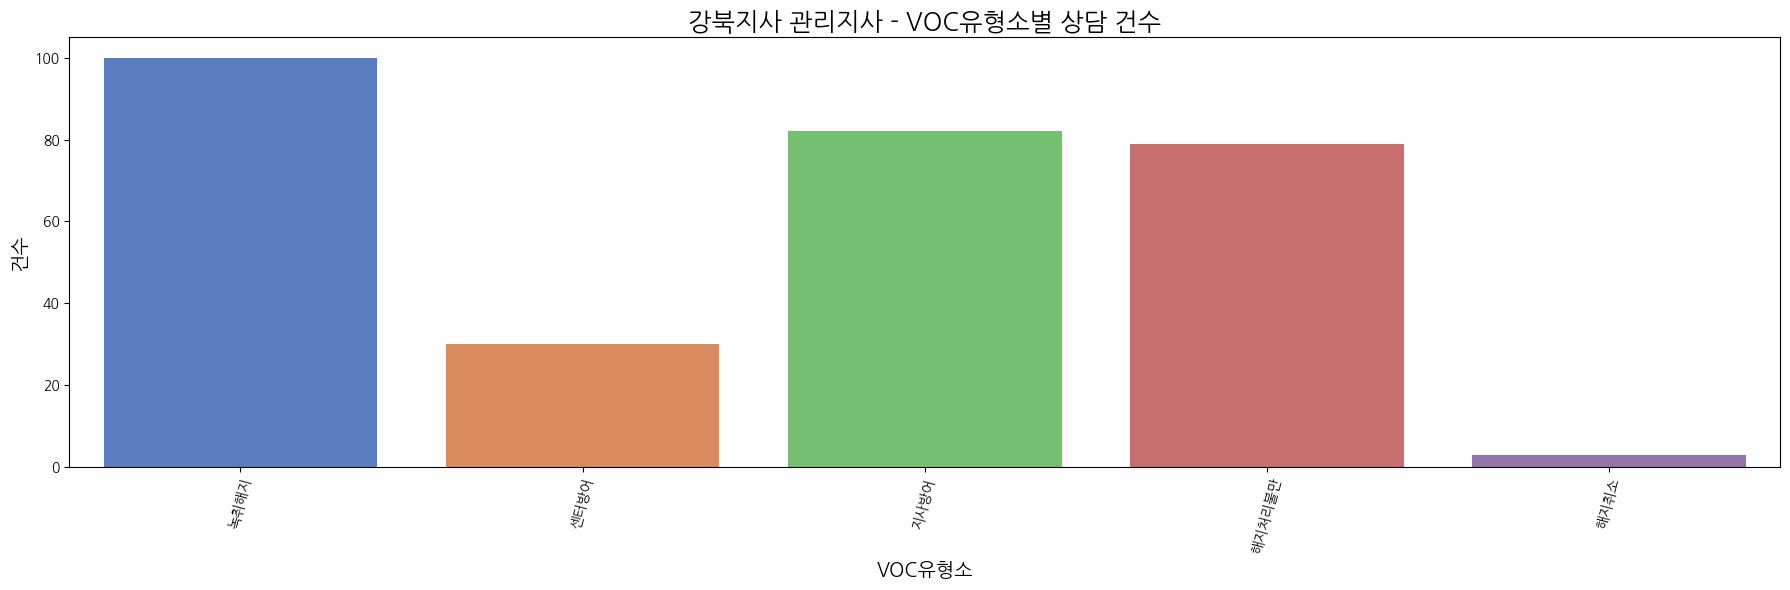

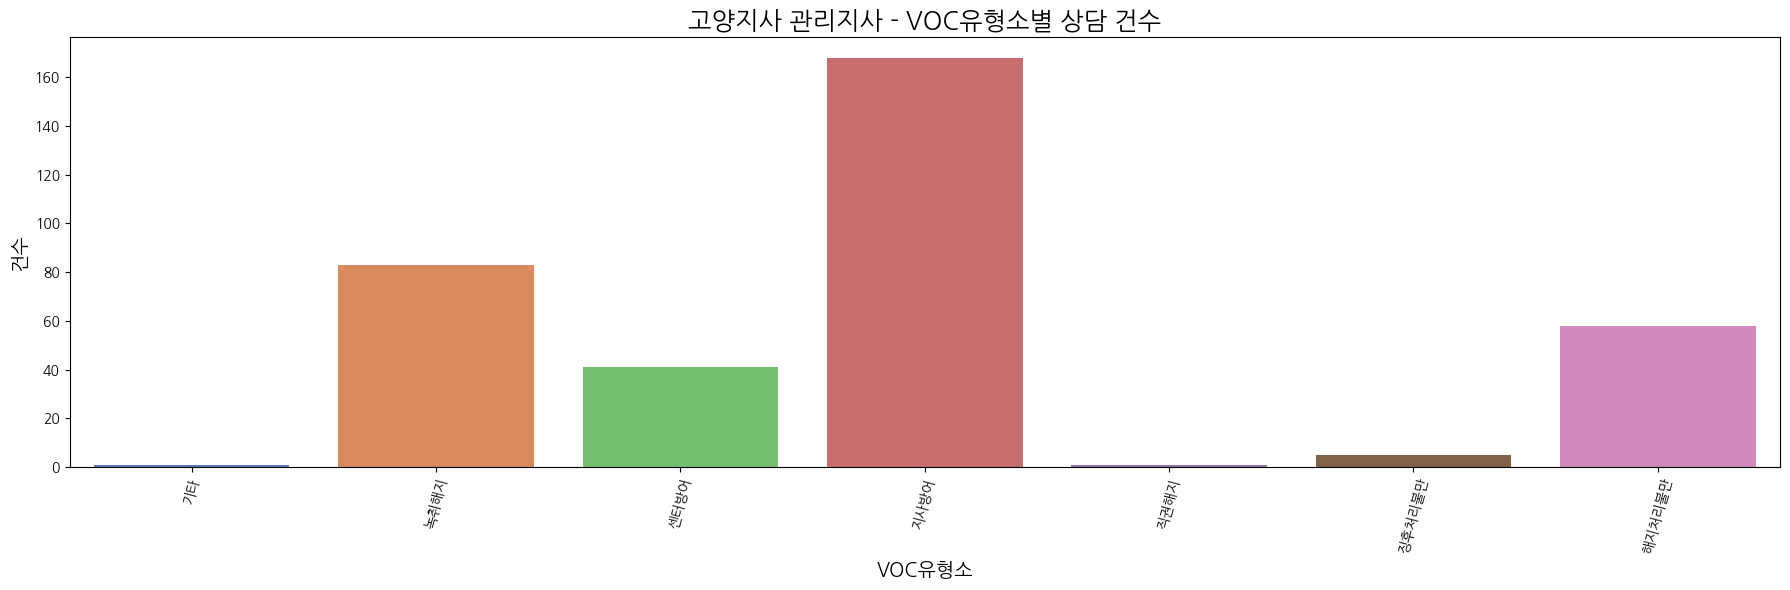

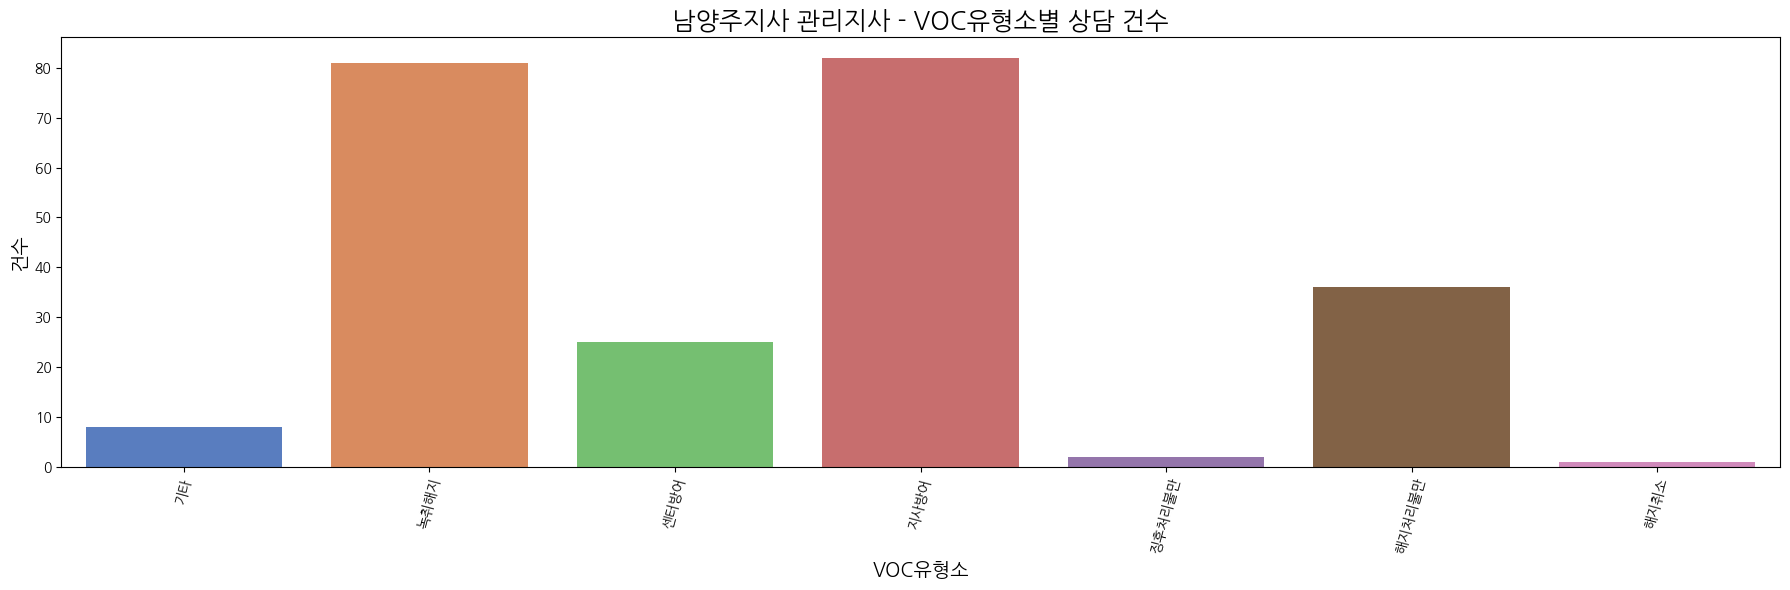

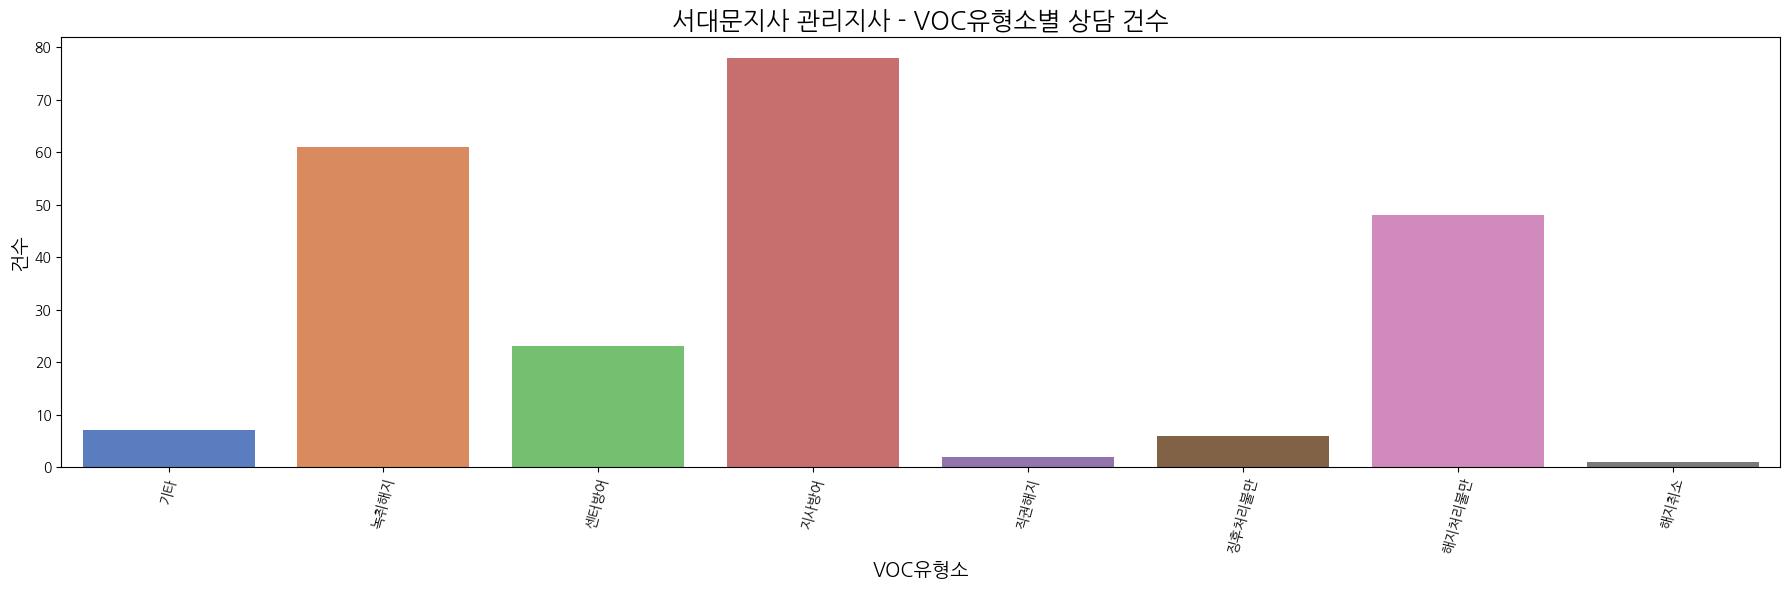

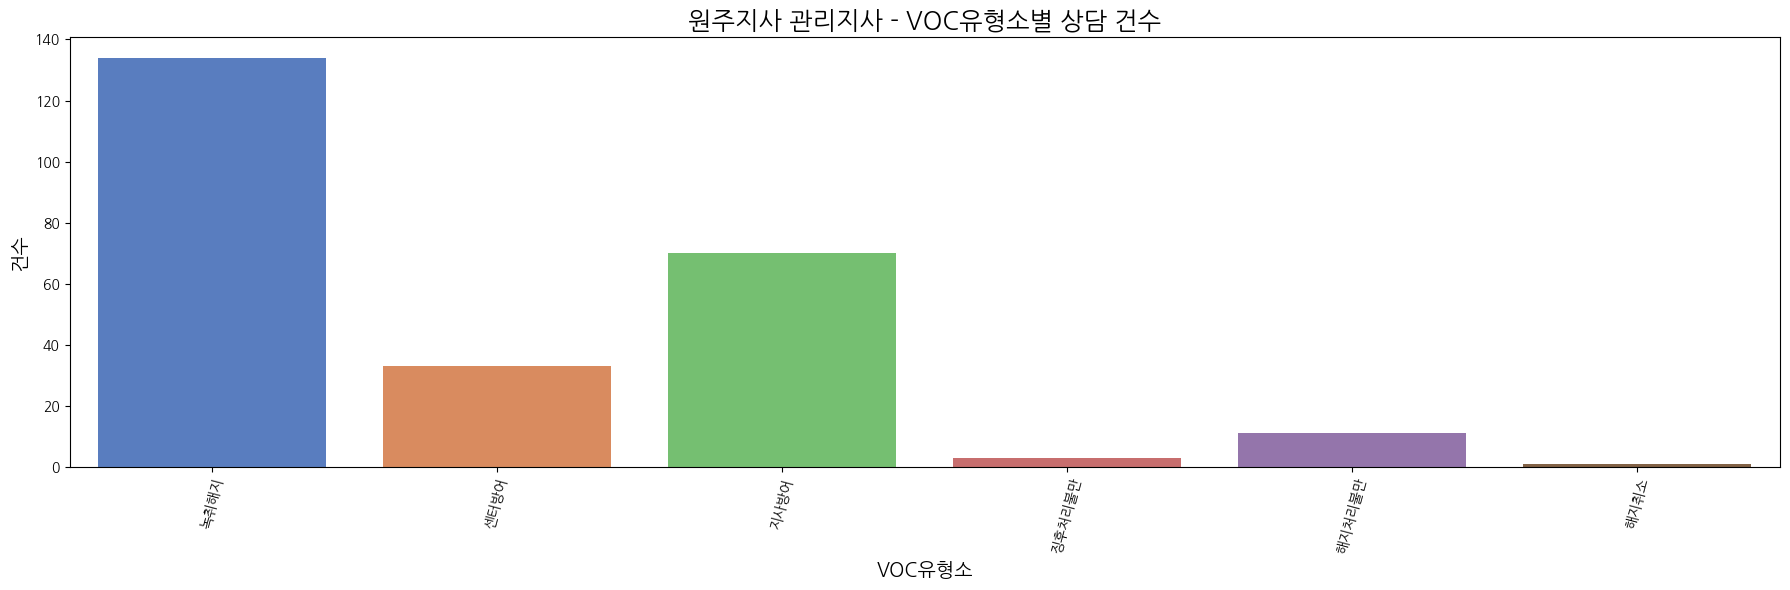

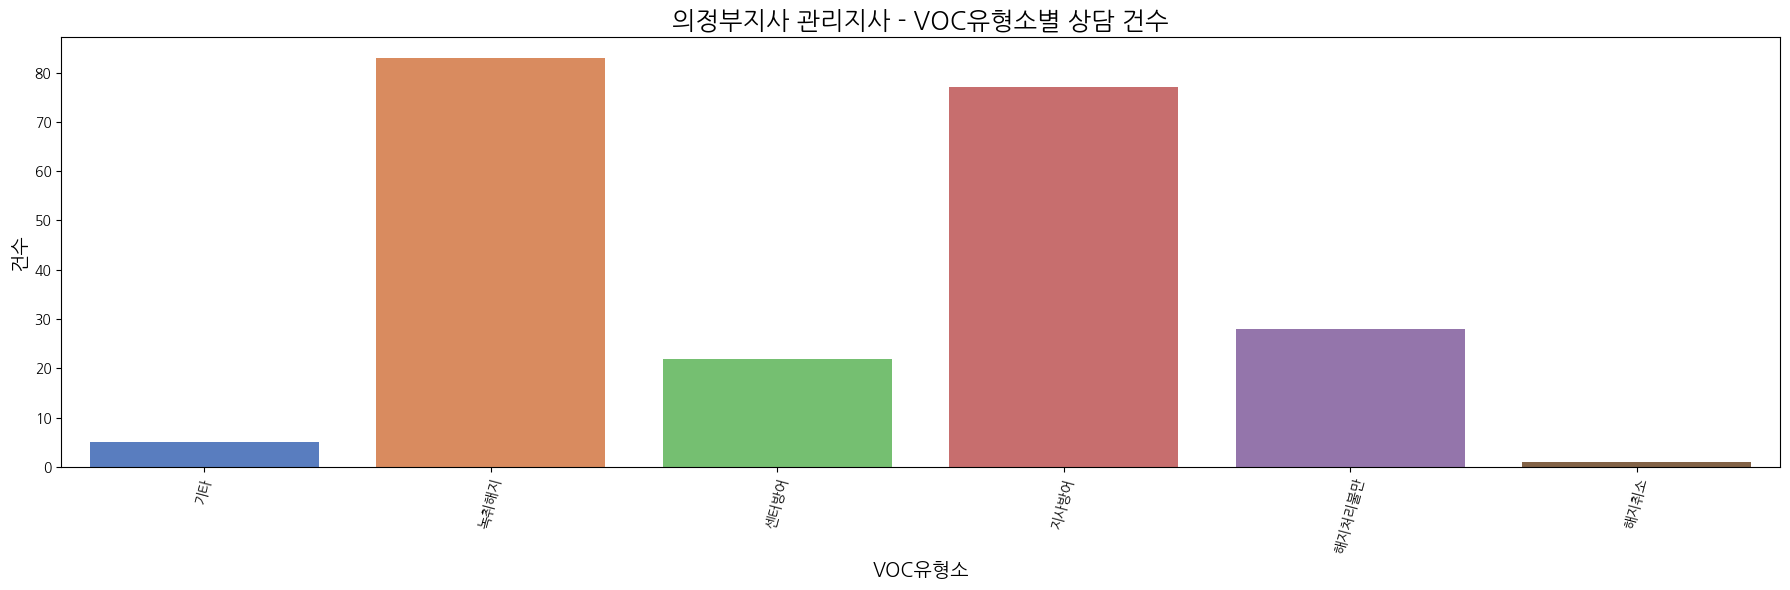

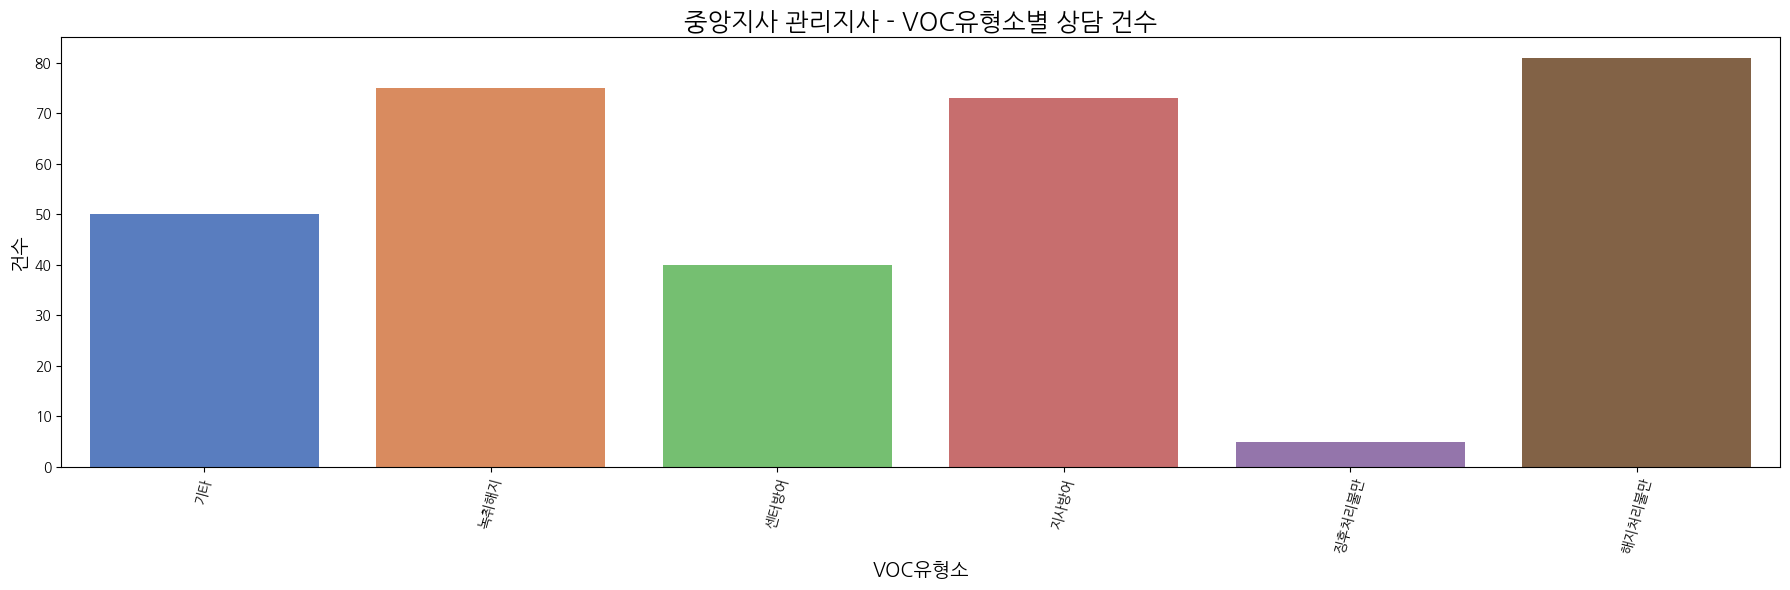

ValueError: Could not interpret value `VOC유형소` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [29]:
# ✅ 1. 나눔고딕 폰트 설치 (최초 1회만)
!apt-get update -qq
!apt-get install -y fonts-nanum -qq > /dev/null

# ✅ 2. 라이브러리 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from gspread_dataframe import get_as_dataframe

# ✅ 3. 한글 폰트 설정 (NanumGothic 적용)
font_dirs = ['/usr/share/fonts/truetype/nanum']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    fm.fontManager.addfont(font_file)

plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False  # 음수 깨짐 방지

print("✅ 나눔고딕 폰트 적용 완료")

# ✅ 4. Google Sheets에서 VOC 데이터 불러오기
json_keyfile_path = "/content/drive/My Drive/Key/credentials.json"
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

sheet_id = "1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY"
sheet_name = "Sheet1"
spreadsheet = client.open_by_key(sheet_id)
worksheet = spreadsheet.worksheet(sheet_name)
df_raw = get_as_dataframe(worksheet, evaluate_formulas=True, header=0)
df_raw.columns = df_raw.columns.str.strip()

print(f"✅ 데이터 로드 완료: {df_raw.shape}")

# ✅ 5. 데이터 정리
df = df_raw[['관리지사', 'VOC유형소']].dropna()

# ✅ 6. 관리지사별 VOC유형소 건수 집계
지사별_voc소 = (
    df.groupby(['관리지사', 'VOC유형소'])
    .size()
    .reset_index(name='건수')
)

# ✅ 7. 전체 관리지사별 VOC유형소 누적 막대그래프
plt.figure(figsize=(22, 10))

for 지사 in 지사별_voc소['관리지사'].unique():
    temp = 지사별_voc소[지사별_voc소['관리지사'] == 지사]
    plt.bar(temp['VOC유형소'], temp['건수'], label=지사)

plt.xticks(rotation=90)
plt.xlabel('VOC 유형소', fontsize=14)
plt.ylabel('건수', fontsize=14)
plt.title('전체 관리지사별 VOC유형소 건수 분포', fontsize=18)
plt.legend(title='관리지사', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ✅ 8. 관리지사별 개별 VOC유형소 그래프
지사목록 = 지사별_voc소['관리지사'].unique()

for 지사 in 지사목록:
    temp = 지사별_voc소[지사별_voc소['관리지사'] == 지사]
    plt.figure(figsize=(18, 6))
    sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')
    plt.title(f'{지사} 관리지사 - VOC유형소별 상담 건수', fontsize=18)
    plt.xticks(rotation=75)
    plt.xlabel('VOC유형소', fontsize=14)
    plt.ylabel('건수', fontsize=14)
    plt.tight_layout()
    plt.show()

# ✅ 9. VOC유형소 상위 10개 시각화
voc소_상위10 = (
    df['VOC유형소']
    .value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'index': 'VOC유형소', 'VOC유형소': '건수'})
)

plt.figure(figsize=(12, 6))
sns.barplot(x='VOC유형소', y='건수', data=voc소_상위10, palette='Set2')
plt.title('VOC유형소 상위 10개 상담건수', fontsize=18)
plt.xticks(rotation=45)
plt.xlabel('VOC유형소', fontsize=14)
plt.ylabel('건수', fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
# ✅ VOC유형소 상위 10개 집계 (완전 수정버전)
voc소_상위10 = (
    df['VOC유형소']
    .value_counts()
    .head(10)
    .reset_index()
)

voc소_상위10.columns = ['VOC유형소', '건수']  # 컬럼명 정확히 수동 설정


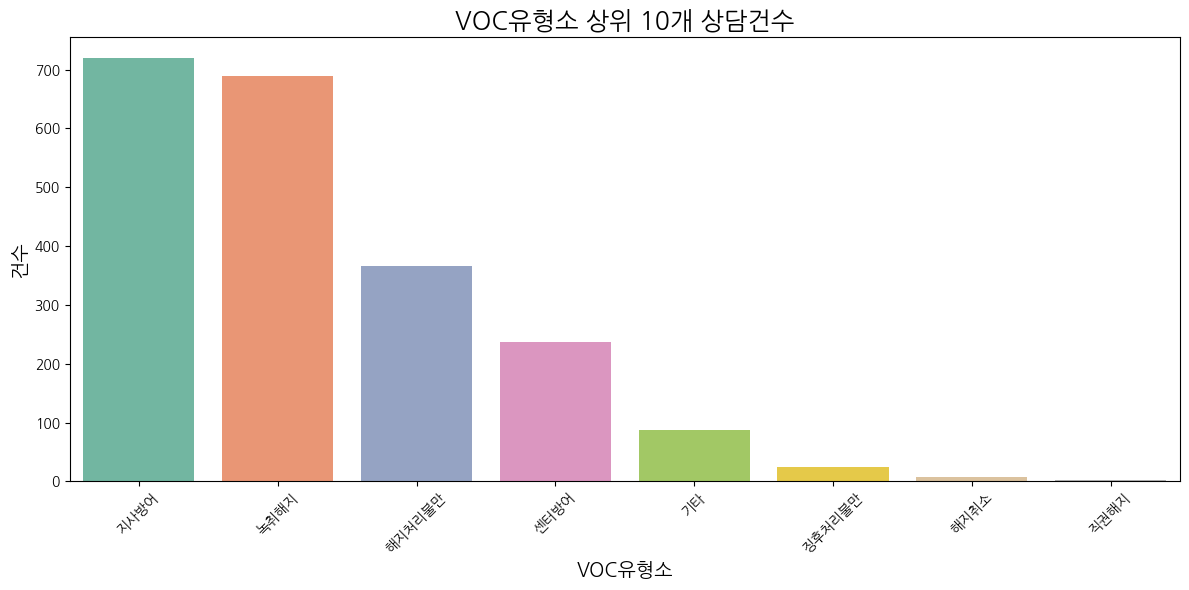

In [11]:
# ✅ VOC유형소 상위 10개 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x='VOC유형소', y='건수', data=voc소_상위10, palette='Set2')
plt.title('VOC유형소 상위 10개 상담건수', fontsize=18)
plt.xticks(rotation=45)
plt.xlabel('VOC유형소', fontsize=14)
plt.ylabel('건수', fontsize=14)
plt.tight_layout()
plt.show()


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ 나눔고딕 폰트 적용 완료
✅ 데이터 로드 완료: (2134, 41)


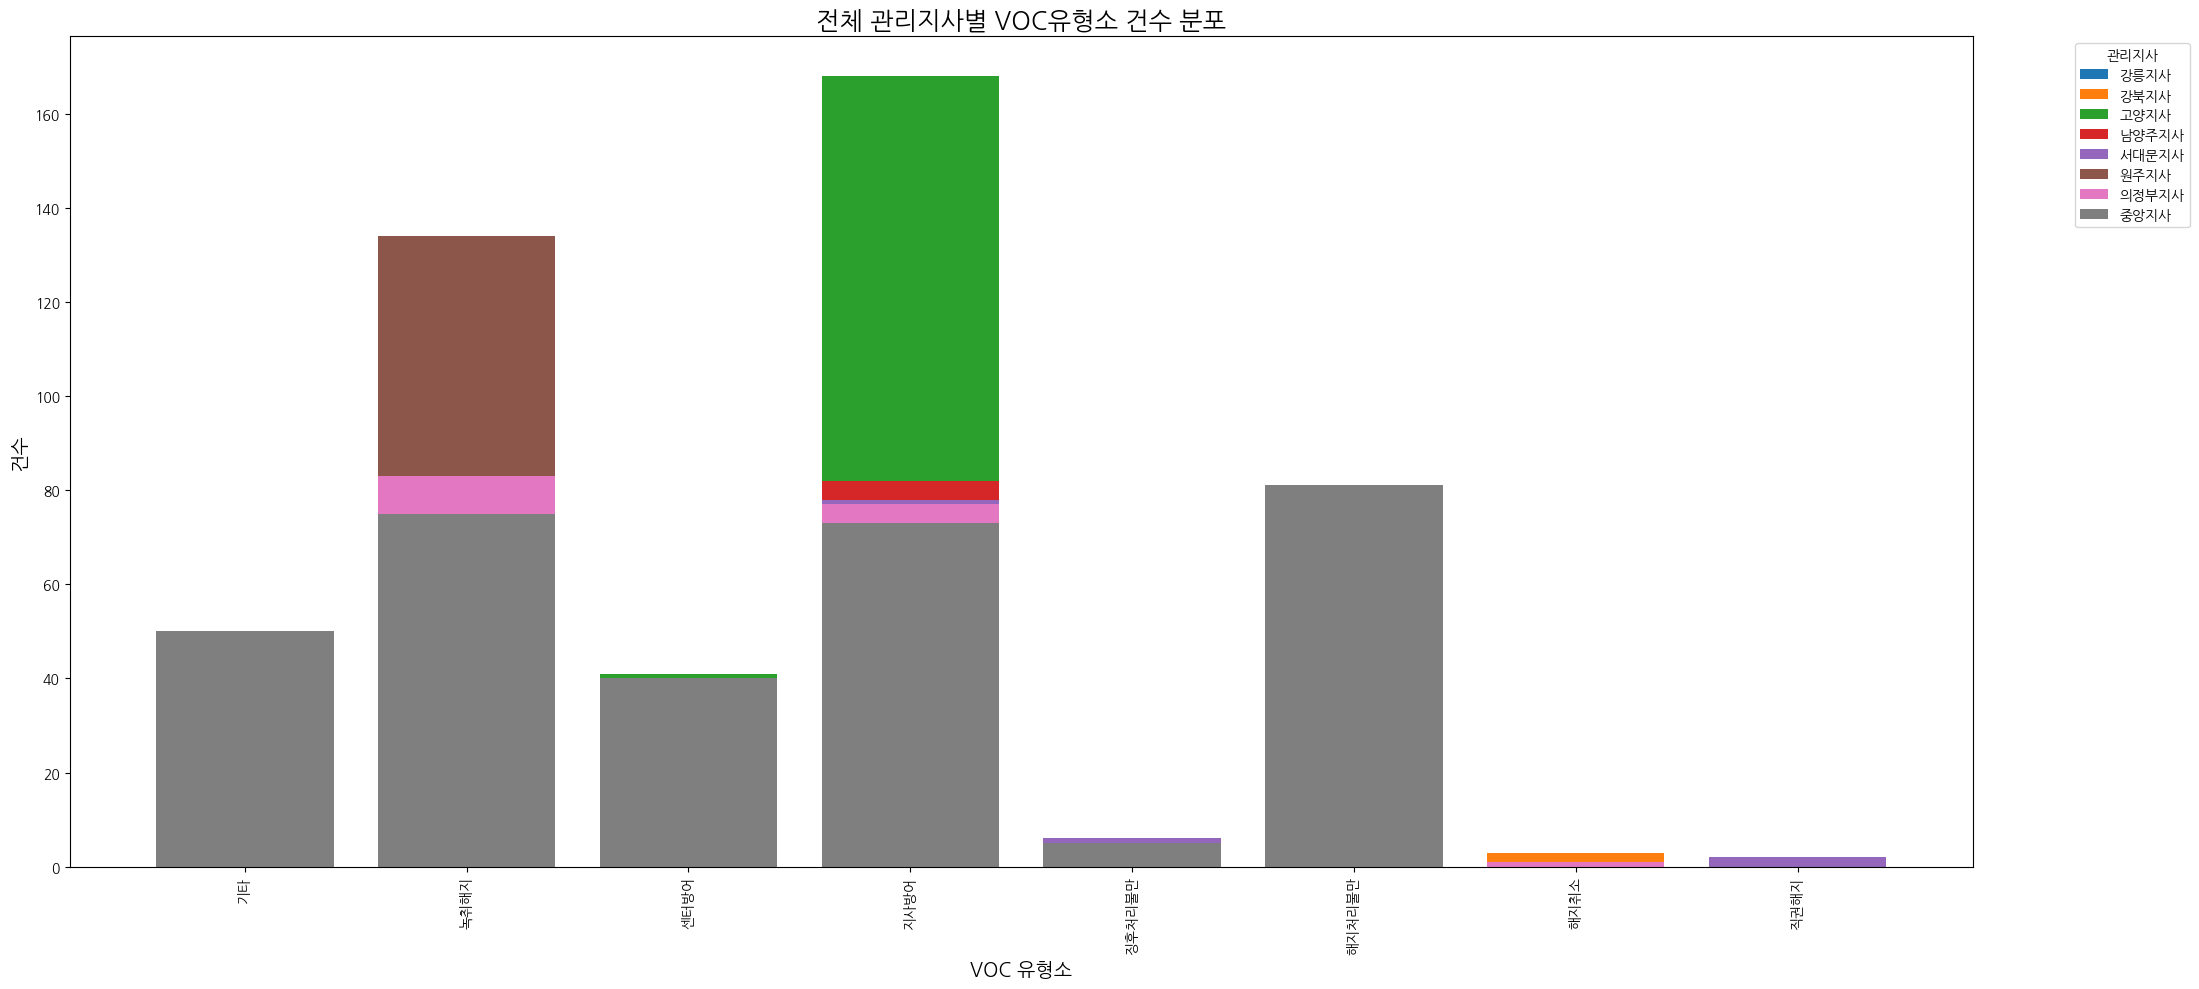

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


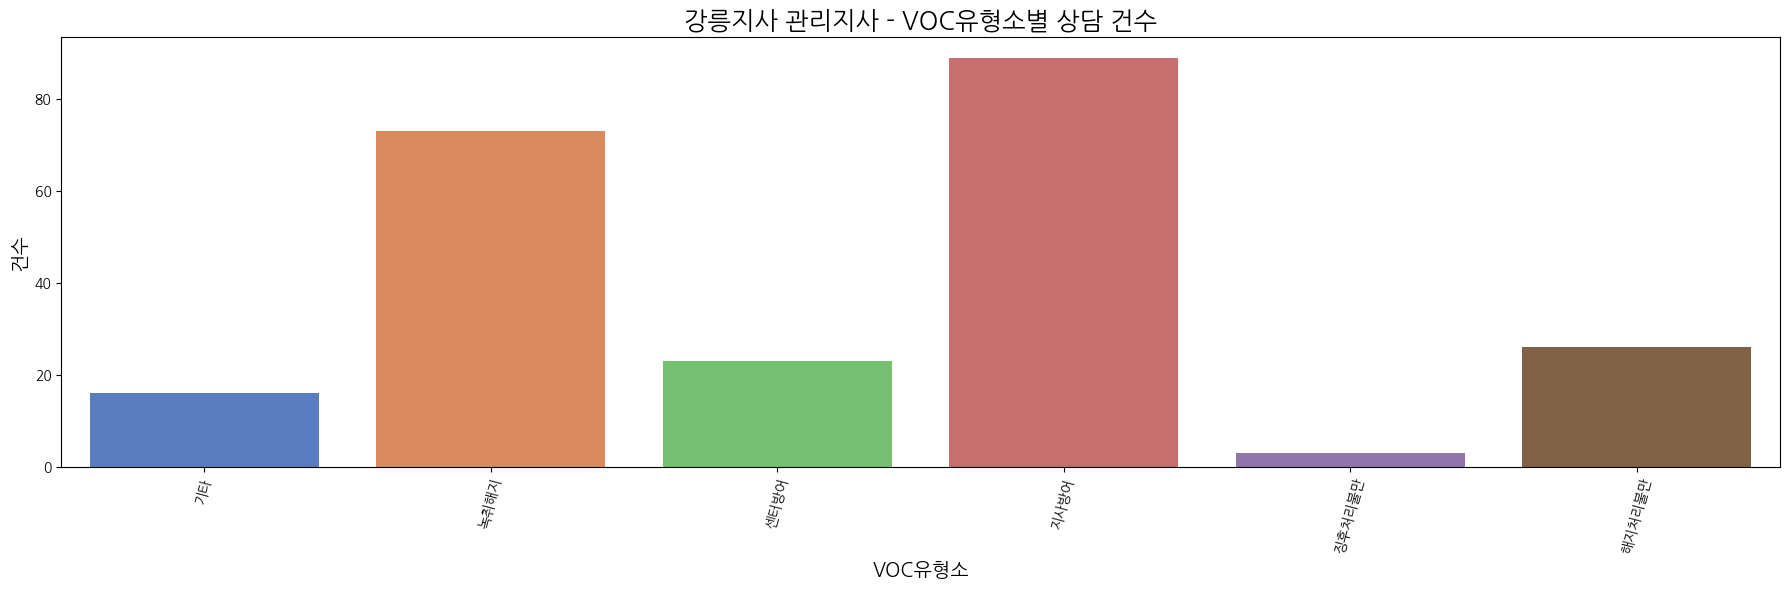

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


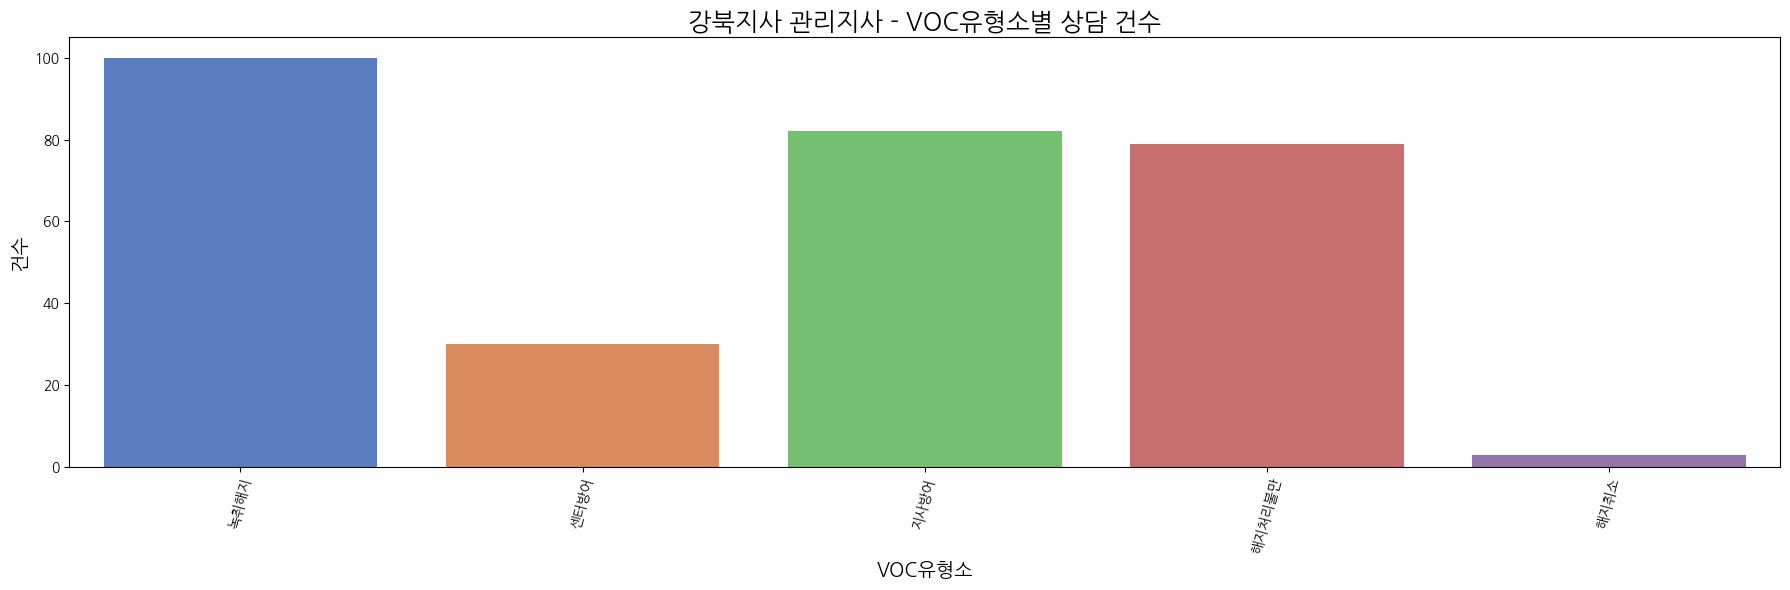

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


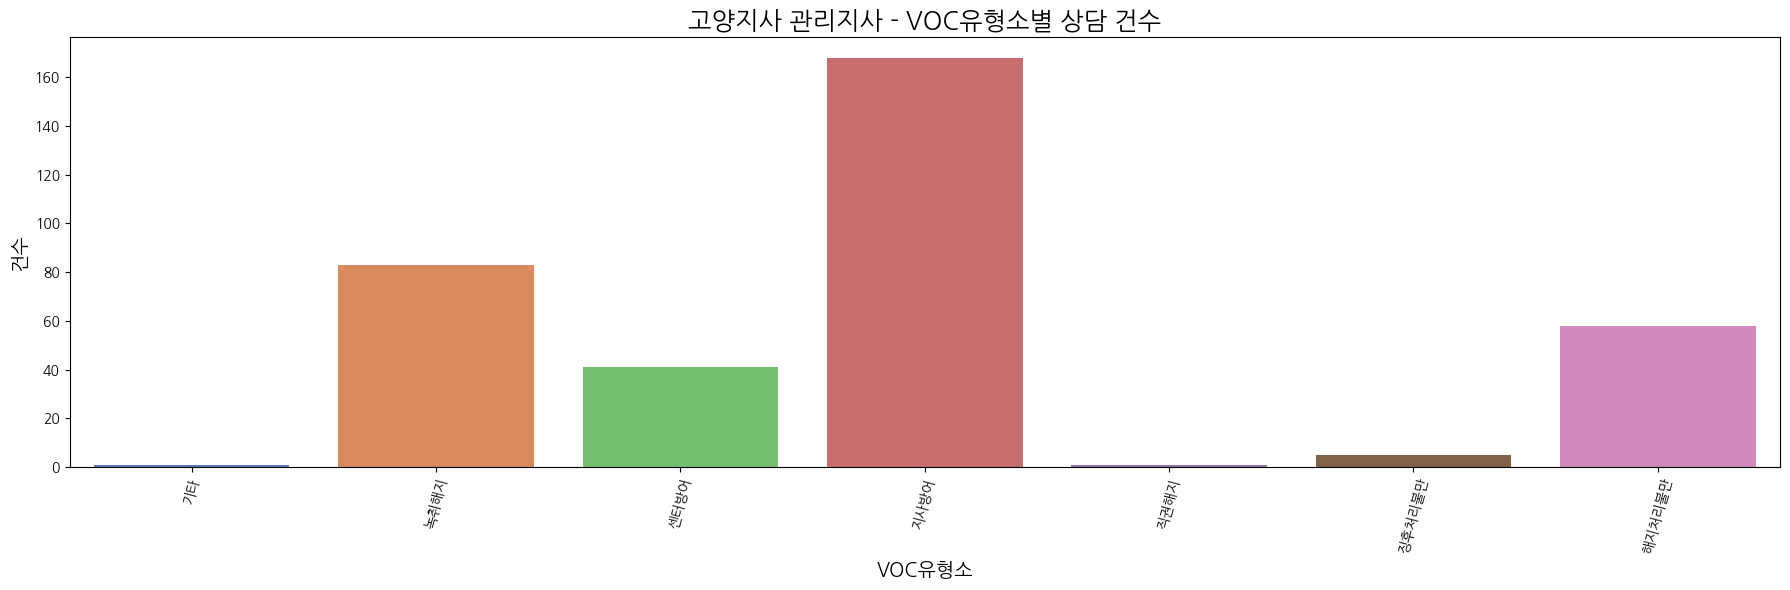

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


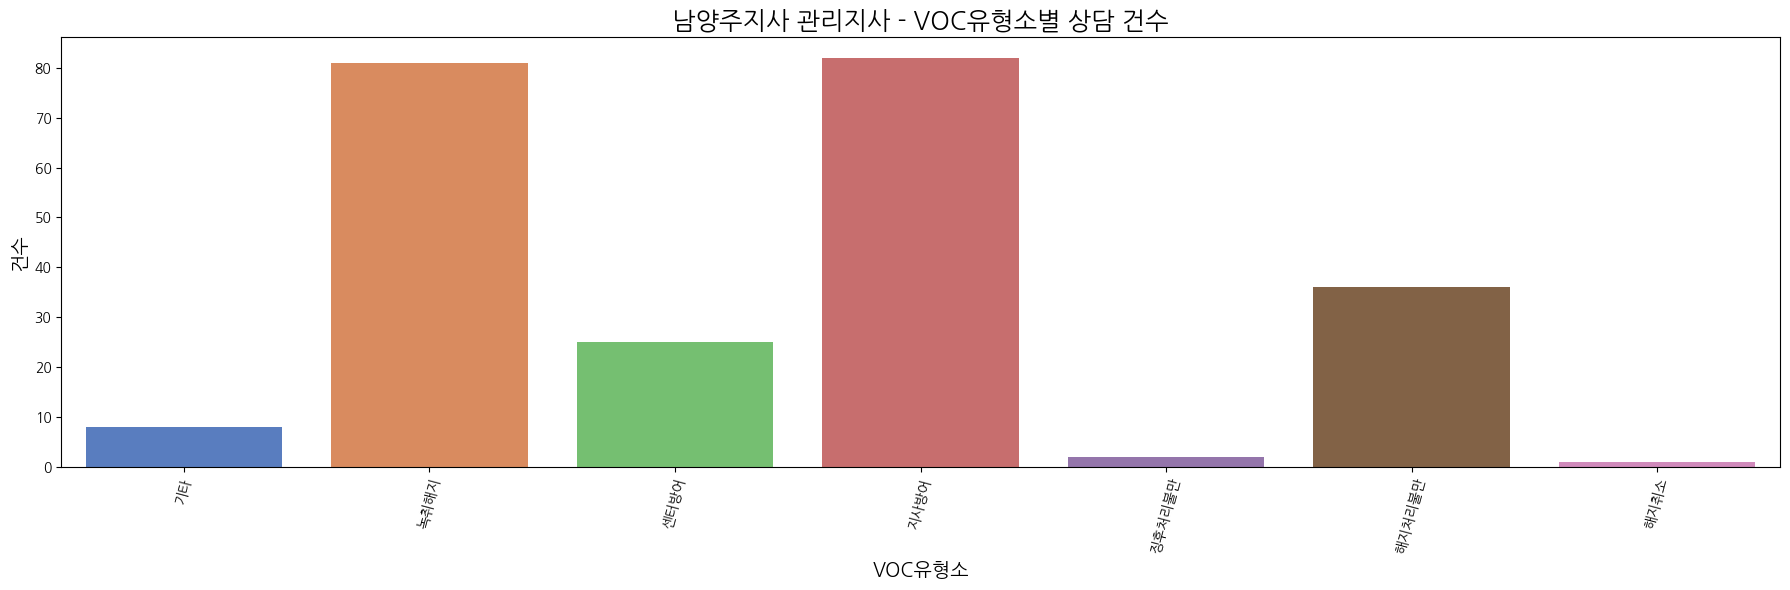

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


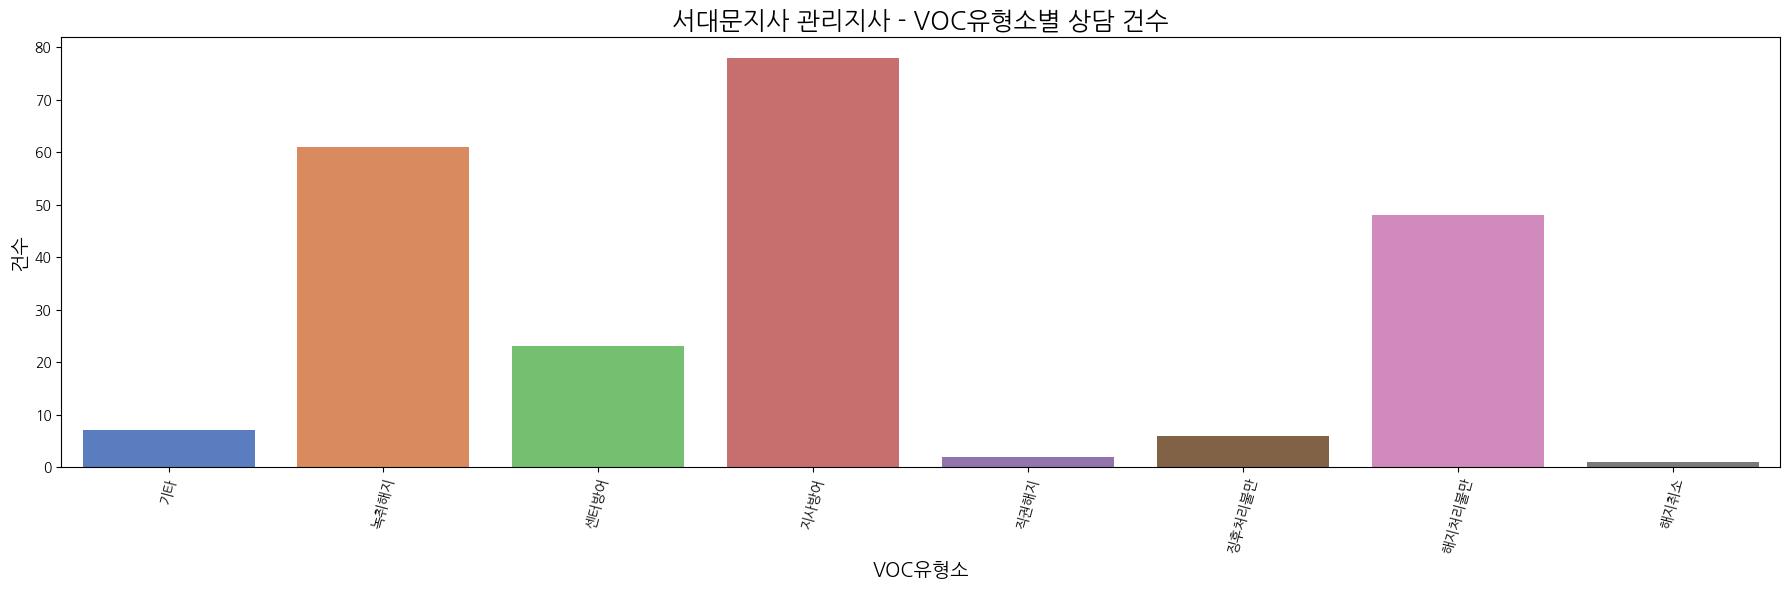

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


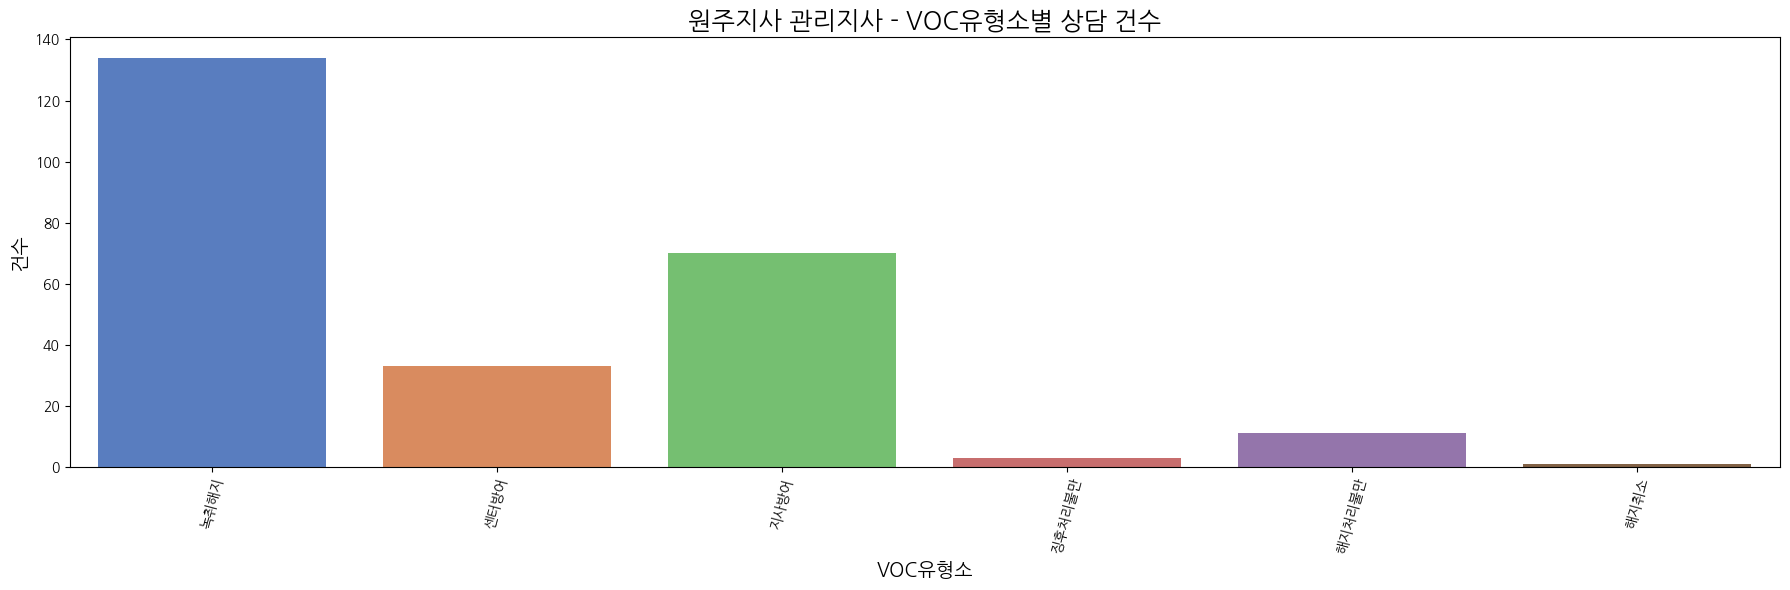

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


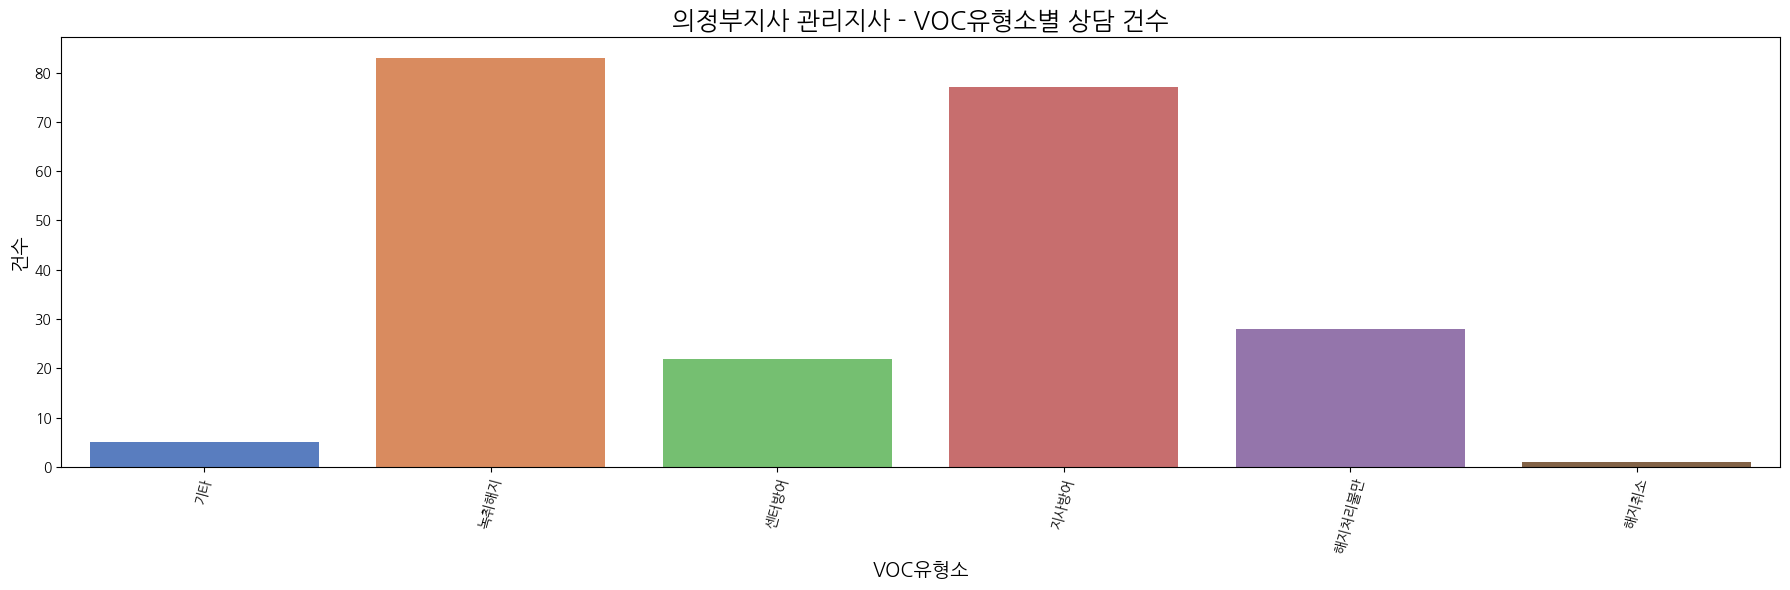

<ipython-input-33-acbffe8c0b59>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=temp, palette='muted')


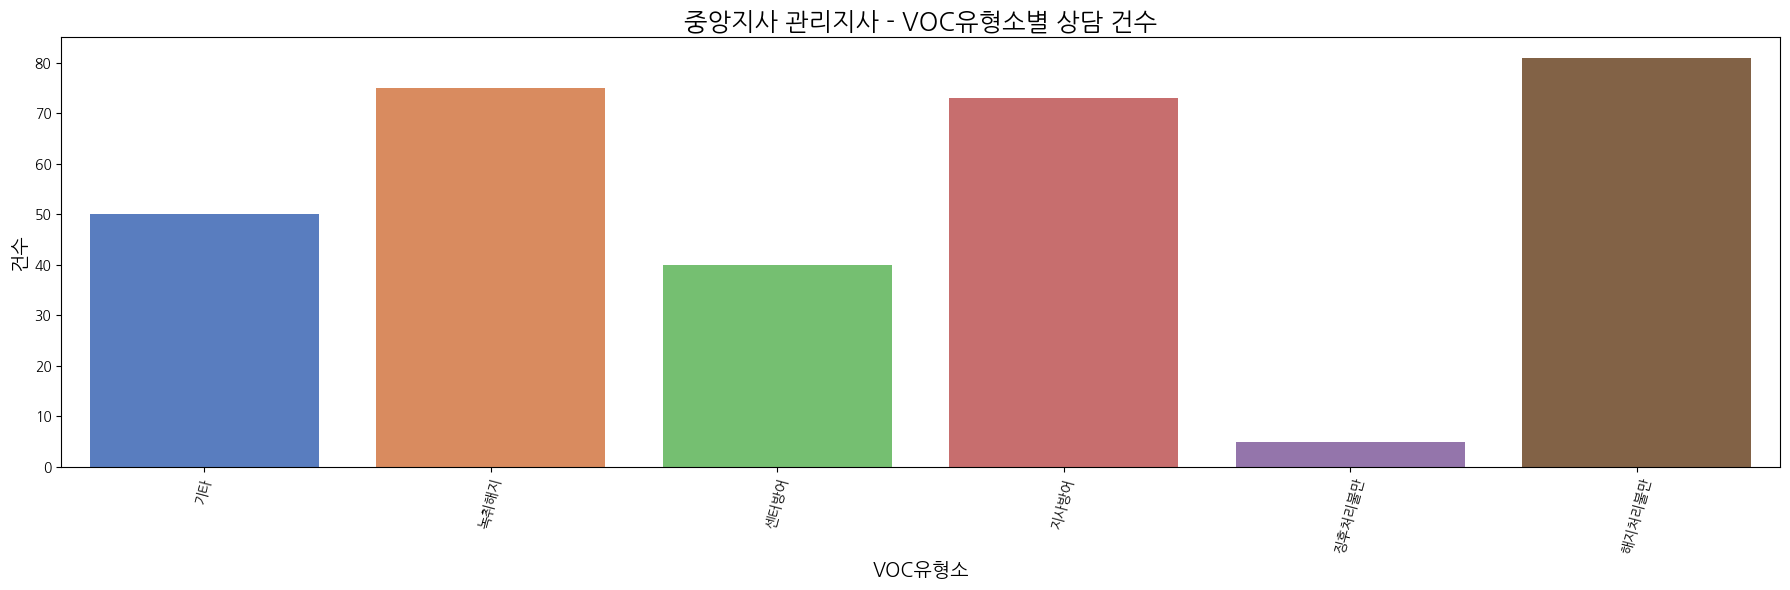

<ipython-input-33-acbffe8c0b59>:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VOC유형소', y='건수', data=voc소_상위10, palette='Set2')


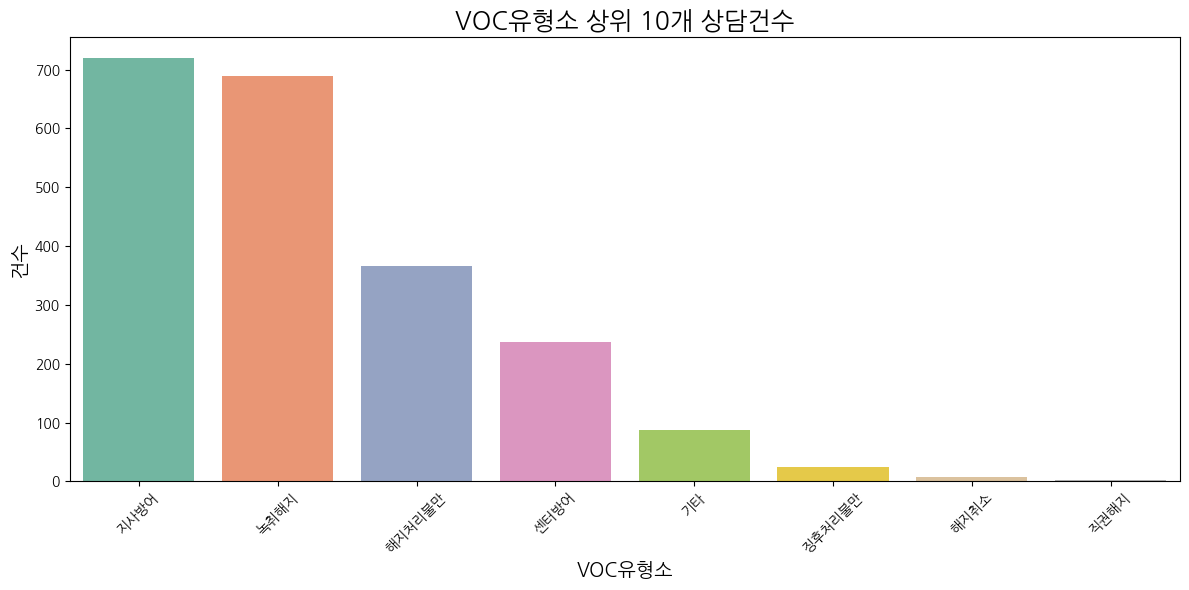

In [20]:
!pip install keybert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [12]:
from keybert import KeyBERT
from transformers import AutoModel

# 한국어 BERT 모델 로드
model = AutoModel.from_pretrained("skt/kobert-base-v1")
kw_model = KeyBERT(model)

# 문서 예시
doc = "고양지사에서 지사방어 관련 VOC가 접수되었습니다."

# 키워드 추출
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None, top_n=5)

print(keywords)

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

[('고양지사에서 지사방어', 0.6142), ('고양지사에서', 0.5774), ('지사방어 관련', 0.4129), ('지사방어', 0.3129), ('voc가 접수되었습니다', 0.3119)]


In [28]:
# ✅ 1. 지사방어 VOC (VOC유형소 기준) 필터링
df_filtered = df_raw.dropna(subset=['VOC유형소', '관리지사'])

# VOC유형소에 '지사방어' 포함된 데이터만
지사방어_df = df_filtered[df_filtered['VOC유형소'].str.contains('지사방어', na=False)]

# 고양지사만 추출
고양지사_지사방어 = 지사방어_df[지사방어_df['관리지사'] == '중앙지사']

print(f"✅ 고양지사 지사방어 건수: {고양지사_지사방어.shape[0]} 건")

# ✅ 2. 고양지사 지사방어 처리자 분포 분석
고양지사_처리자분포 = (
    고양지사_지사방어['처리자']
    .value_counts()
    .reset_index()
    .rename(columns={'index': '처리자', '처리자': '건수'})
)

from IPython.display import display
print("✅ 고양지사 지사방어 처리자별 분포")
display(고양지사_처리자분포)

# ✅ 3. 고양지사 지사방어 처리내용 토픽 분석 준비
고양지사_처리내용 = 고양지사_지사방어['처리내용'].dropna()

print(f"✅ 처리내용 텍스트 데이터 개수: {len(고양지사_처리내용)}")

# ✅ 4. 토픽 분석 (KeyBERT 기반 키워드 추출)
from keybert import KeyBERT

kw_model = KeyBERT(model='distiluse-base-multilingual-cased')

# 처리내용별 핵심 키워드 추출
토픽리스트 = []

for 문장 in 고양지사_처리내용:
    키워드 = kw_model.extract_keywords(문장, keyphrase_ngram_range=(1, 3), stop_words=None, top_n=1)
    if 키워드:
        토픽리스트.append(키워드[0][0])  # 가장 높은 점수 키워드만 선택

# ✅ 5. 토픽 분포 집계
import pandas as pd

토픽분포 = pd.Series(토픽리스트).value_counts().reset_index()
토픽분포.columns = ['토픽', '건수']

print("✅ 고양지사 처리내용 기반 토픽 분석 결과")
display(토픽분포)

✅ 고양지사 지사방어 건수: 73 건
✅ 고양지사 지사방어 처리자별 분포


,건수,count
0,한현석,25
1,,15
2,남기민,13
3,문성진,8
4,이진백,5
5,권대호,4
6,이재용,2
7,오광훈,1


✅ 처리내용 텍스트 데이터 개수: 73
✅ 고양지사 처리내용 기반 토픽 분석 결과


,토픽,건수
0,해지,1


In [19]:
# 다시 정리

In [16]:
# 필수 라이브러리 설치
!pip install gspread oauth2client keybert

# 라이브러리 불러오기
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from google.colab import auth
from google.colab import drive
from keybert import KeyBERT
from datetime import datetime

# Google Drive 마운트
drive.mount('/content/drive')

# Google 인증
auth.authenticate_user()
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
json_keyfile_path = '/content/drive/My Drive/Key/credentials.json'  # 사용자에 맞게 경로 수정
creds = ServiceAccountCredentials.from_json_keyfile_name(json_keyfile_path, scope)
client = gspread.authorize(creds)

# Google Sheets에서 데이터 불러오기
sheet_id = '1T63oteDqGdZS1d6v29UHYVlFm4YEoDzGNnauo-nTosY'  # 사용자에 맞게 수정
sheet_name = 'Sheet1'  # 사용자에 맞게 수정
worksheet = client.open_by_key(sheet_id).worksheet(sheet_name)
data = worksheet.get_all_records()
df_raw = pd.DataFrame(data)
df_raw.columns = df_raw.columns.str.strip()  # 컬럼명 공백 제거

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# 날짜 컬럼을 datetime 형식으로 변환
df_raw['접수일시'] = pd.to_datetime(df_raw['접수일시'], errors='coerce')

# 연도, 월, 일 컬럼 추가
df_raw['연도'] = df_raw['접수일시'].dt.year
df_raw['월'] = df_raw['접수일시'].dt.month
df_raw['일'] = df_raw['접수일시'].dt.day

# 예시: 2025년 4월 데이터 필터링
df_filtered = df_raw[(df_raw['연도'] == 2025) & (df_raw['월'] == 4)]

In [25]:
# 등록내용 컬럼에서 결측치 제거
text_data = df_filtered['등록내용'].dropna().tolist()

# KeyBERT 모델 초기화
kw_model = KeyBERT(model='distiluse-base-multilingual-cased')

# 키워드 추출
keywords = []
for doc in text_data:
    kw = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 3), stop_words=None, top_n=1)
    if kw:
        keywords.append(kw[0][0])

# 키워드 분포 계산
keyword_df = pd.Series(keywords).value_counts().reset_index()
keyword_df.columns = ['키워드', '건수']

In [26]:
# 관리지사, 영업구역, 처리자, 계약번호 기준 건수 및 월정료 합계
metrics = df_filtered.groupby(['관리지사', '담당상세', '처리자', '계약번호']).agg({
    '접수번호': 'count',
    '월정료(VAT미포함)': 'sum'
}).reset_index()
metrics.rename(columns={'접수번호': '건수', '월정료(VAT미포함)': '월정료합계'}, inplace=True)

In [27]:
# Google Sheets에 새로운 시트로 저장
from gspread_dataframe import set_with_dataframe

# 새 Google Sheets 파일 생성
new_sheet = client.create('VOC_분석_결과')

# 키워드 분포 저장
worksheet_keywords = new_sheet.add_worksheet(title='키워드_분포', rows=1000, cols=20)
set_with_dataframe(worksheet_keywords, keyword_df)

# 지표 계산 결과 저장
worksheet_metrics = new_sheet.add_worksheet(title='지표_계산', rows=1000, cols=20)
set_with_dataframe(worksheet_metrics, metrics)

# 원본 필터링된 데이터 저장
worksheet_filtered = new_sheet.add_worksheet(title='필터링된_데이터', rows=1000, cols=20)
set_with_dataframe(worksheet_filtered, df_filtered)

print(f"분석 결과가 저장된 Google Sheets 링크: https://docs.google.com/spreadsheets/d/{new_sheet.id}")

분석 결과가 저장된 Google Sheets 링크: https://docs.google.com/spreadsheets/d/1U5QoFDnujG-hokVsUphQphWbDy6NOOMNh9Av_YY3BKI
